**Test on the the accuracy of different eigensolver**



In [1]:
import cupy as xp
import numpy as np
import scipy as sp
from scipy import sparse

In [2]:
#load H
H = sparse.load_npz('saveH.npz')
#use full numpy eigsolver
vl0,vt0 = np.linalg.eigh(H.todense())

In [3]:
print(vl0)

[0.01976539 0.02004856 0.0230247  ... 0.96232045 0.9672998  0.9758419 ]


In [4]:
vec_np = np.ravel(vt0[:,-1])
print(vec_np)

[-0.00633714+0.0000000e+00j -0.00836839-1.3662302e-06j
 -0.01070476-1.4593508e-07j ... -0.00109922+4.1308748e-08j
 -0.00266583+4.4546734e-08j -0.00440245-4.9364498e-06j]


In [5]:
#scipy
v0 = np.ones((H.shape[0],),dtype = np.complex64)
vl1,vt1 = sp.sparse.linalg.eigsh(H, k=6, M=None, sigma=None, which='LM', v0=v0, ncv=None, maxiter=None, tol=0, return_eigenvectors=True, Minv=None, OPinv=None, mode='normal')

In [6]:
print(vl1)

[0.9758403  0.9672966  0.96231776 0.95920104 0.9529065  0.95051986]


In [7]:
vec_sp = np.ravel(vt1[:,0])
print(vec_sp)

[-0.00633644-8.08128425e-06j -0.00836746-1.20379245e-05j
 -0.01070357-1.37972529e-05j ... -0.00109911-1.36034214e-06j
 -0.00266553-3.35519690e-06j -0.00440196-1.05500085e-05j]


In [8]:
#cupyx
import cupyx,scipy.sparse
from cupyx.scipy.sparse.linalg import eigsh
vl2, vt2 = eigsh(cupyx.scipy.sparse.csr_matrix(H), k=6,v0 = xp.asarray(v0),ncv = 18,  maxiter = None,which="LM", tol=0,return_eigenvectors = True)

In [9]:
print(vl2)

[0.95052123 0.9529093  0.9592052  0.9623204  0.9672998  0.9758419 ]


In [10]:
vec_cupyx = xp.ravel(vt2[:,-1])
print(vec_cupyx)

[0.00633713+8.0739965e-06j 0.00836838+1.2028170e-05j
 0.01070475+1.3784621e-05j ... 0.00109922+1.3591954e-06j
 0.00266583+3.3519073e-06j 0.00440244+1.0545481e-05j]


power iteration

In [13]:
v0 = xp.ones((H.shape[0],),dtype = xp.complex64)
H0 = cupyx.scipy.sparse.csr_matrix(H)
for _ in range(1000):
    v0 = H0 * v0
vt3 = v0/xp.linalg.norm(v0)

In [127]:
v0 = xp.ones((H.shape[0],),dtype = xp.complex64)
v0 /= xp.linalg.norm(v0)
H0 = cupyx.scipy.sparse.csr_matrix(H)

v1 = H0 * v0
alpha = xp.dot(xp.conj(v1), v0)
v0 -=   alpha * v1 

for _ in range(10):
    v1 = v0 + 0 
    v0 = H0 @ v0

 #alpha = xp.dot(xp.conj(v0), v1) /xp.dot(xp.conj(v1), v1)
vt3 = v0

lambda1 = xp.matmul(vt3.conj().transpose() * H0 , vt3)/xp.linalg.norm(vt3)**2

print(lambda1, xp.linalg.norm(H0 @ vt3 - lambda1*vt3) )

print('alpha', alpha)

(0.95439726-6.342793e-12j) 0.0037070706
alpha (0.8158332-1.8189894e-12j)


In [126]:
v0 = xp.ones((H.shape[0],),dtype = xp.complex64)
v0 /= xp.linalg.norm(v0)
H0 = cupyx.scipy.sparse.csr_matrix(H)

for _ in range(10):
    
    v0 = H0 @ v0

 #alpha = xp.dot(xp.conj(v0), v1) /xp.dot(xp.conj(v1), v1)
vt3 = v0

lambda1 = xp.matmul(vt3.conj().transpose() * H0 , vt3)/xp.linalg.norm(vt3)**2

print(lambda1, xp.linalg.norm(H0 @ vt3 - lambda1*vt3) )

print('alpha', alpha)

(0.96139926+1.1931521e-12j) 0.012193055
alpha (0.8158332-1.8189894e-12j)


In [107]:
vec_power = xp.ravel(vt3)
print(vec_power)

[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]


In [108]:
vec_power = xp.ravel(vt3)
print(vec_power)

[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]


In [91]:
print(xp.mean(H0*vt3/vt3))
vt3 = xp.reshape(vt3,(4096,1))
print(xp.matmul(vt3.conj().transpose() * H0 , vt3)/xp.linalg.norm(vt3)**2)
print(vt3.shape,H0.shape)
print(((vt3.conj().transpose() @ H0) @ vt3)/xp.linalg.norm(vt3)**2)

(0.81746703-0.0028794138j)
[[0.8431747+2.5465852e-11j]]
(4096, 1) (4096, 4096)
[[0.8431747+2.1827873e-11j]]


In [17]:
print(xp.linalg.norm(vec_np-vec_sp))
print(np.linalg.norm(vec_sp + vec_cupyx.get()))
print(xp.linalg.norm(vec_cupyx - vec_power))

0.0012754265
5.8681686e-05
9.744947e-07


using GPU
loaded data, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
Split and Overlap, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
geometry: img size: (317, 317) frames: (16, 16, 4096)
not refining illumination, starting with good one, maxiter: 100
start AP memory used, and total: 16533504 458135552
normalized by data.nbytes memory used and total normalized: 3.94189453125 109.22802734375
data size 4194304
----
after Prox_data, memory used, and total: 16567296 458135552
normalized by data.nbytes memory used and total normalized: 3.949951171875 109.22802734375
----
after frames initial, memory used, and total: 24955904 458135552
normalized by data.nbytes memory used and total normalized: 5.949951171875 109.22802734375
----
start loop, memory used, and total: 34184192 4581355

  0%|          | 0/100 [00:00<?, ?it/s]

1111 9.979505e-07


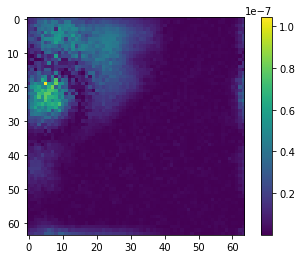

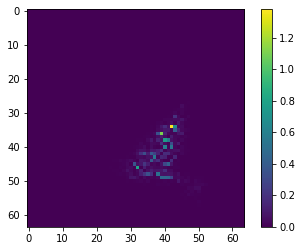

  1%|          | 1/100 [00:04<06:59,  4.23s/it]

1111 9.89721e-07


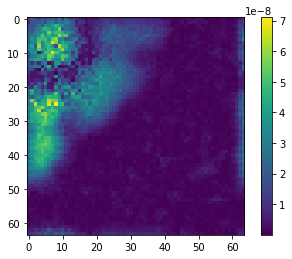

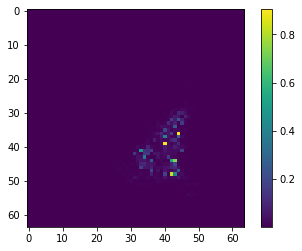

  2%|▏         | 2/100 [00:04<03:19,  2.03s/it]

1111 8.325237e-07


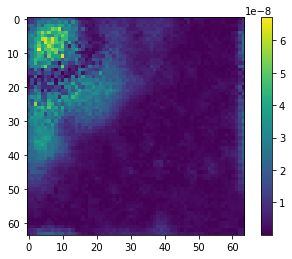

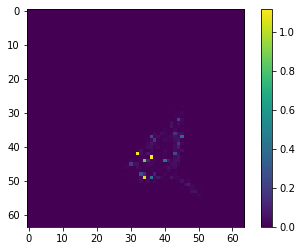

  3%|▎         | 3/100 [00:05<02:08,  1.33s/it]

1111 6.31775e-07


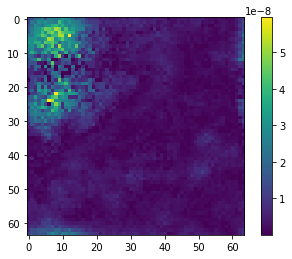

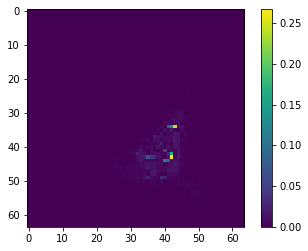

  4%|▍         | 4/100 [00:05<01:35,  1.01it/s]

1111 8.738472e-07


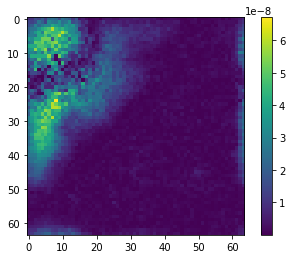

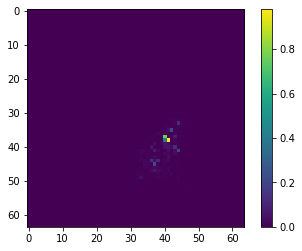

  5%|▌         | 5/100 [00:06<01:17,  1.23it/s]

1111 8.352302e-07


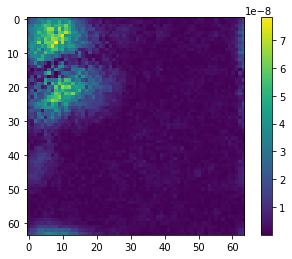

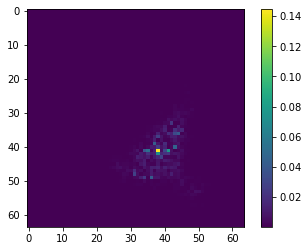

  6%|▌         | 6/100 [00:06<01:06,  1.42it/s]

1111 8.8033585e-07


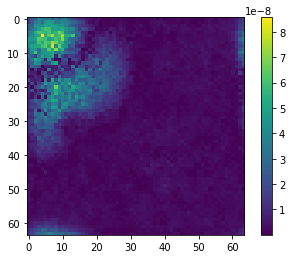

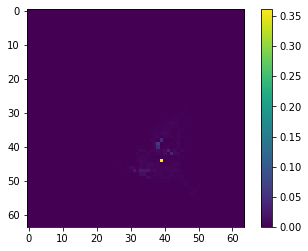

  7%|▋         | 7/100 [00:07<01:02,  1.50it/s]

1111 8.433873e-07


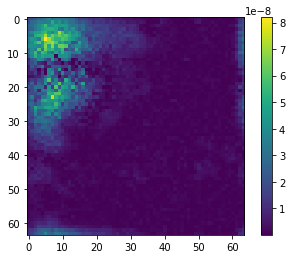

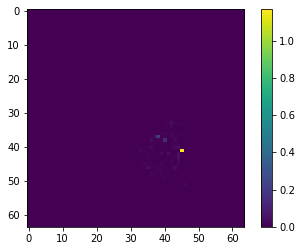

  8%|▊         | 8/100 [00:07<00:56,  1.64it/s]

1111 8.2708334e-07


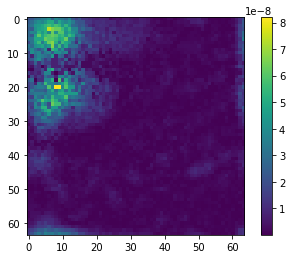

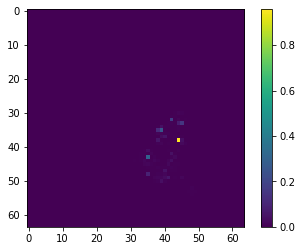

  9%|▉         | 9/100 [00:08<00:52,  1.74it/s]

1111 8.146891e-07


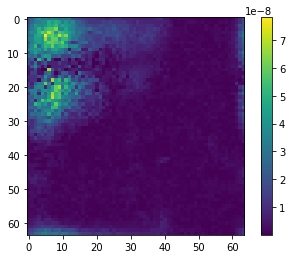

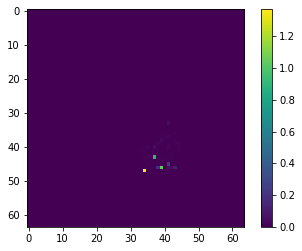

 10%|█         | 10/100 [00:08<00:49,  1.81it/s]

1111 7.6641874e-07


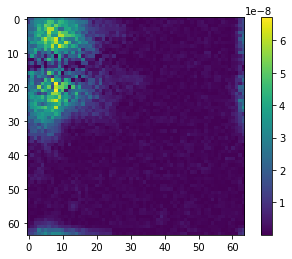

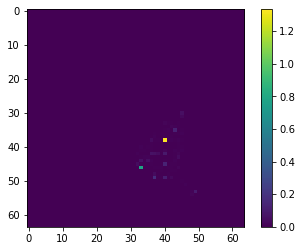

 11%|█         | 11/100 [00:09<00:47,  1.88it/s]

1111 7.7305384e-07


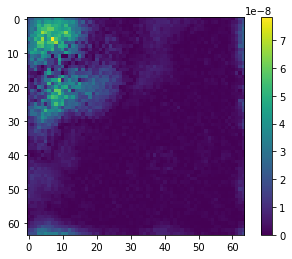

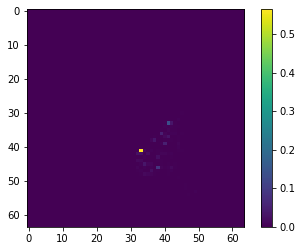

 12%|█▏        | 12/100 [00:09<00:45,  1.92it/s]

1111 8.514569e-07


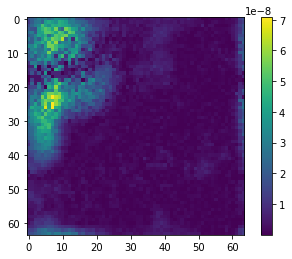

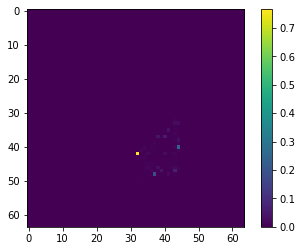

 13%|█▎        | 13/100 [00:10<00:44,  1.95it/s]

1111 8.5274456e-07


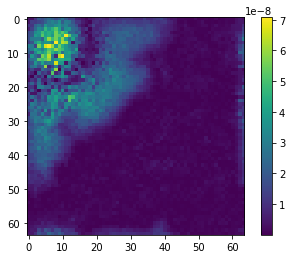

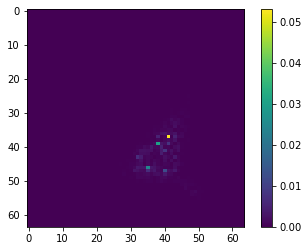

 14%|█▍        | 14/100 [00:10<00:45,  1.87it/s]

1111 9.89034e-07


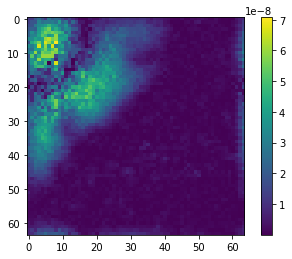

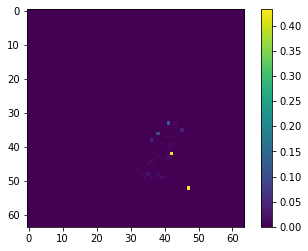

 15%|█▌        | 15/100 [00:11<00:44,  1.91it/s]

1111 1.1230001e-06


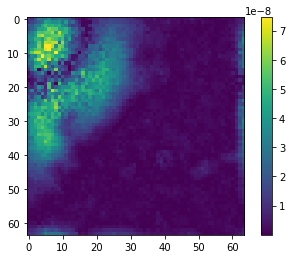

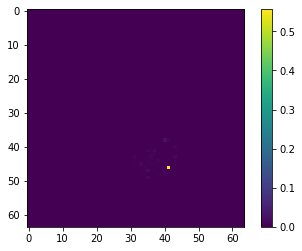

 16%|█▌        | 16/100 [00:11<00:43,  1.95it/s]

1111 7.551321e-07


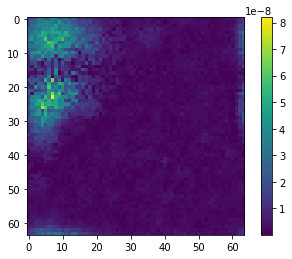

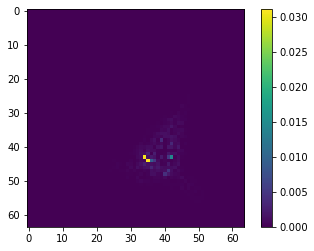

 17%|█▋        | 17/100 [00:12<00:42,  1.96it/s]

1111 7.2607065e-07


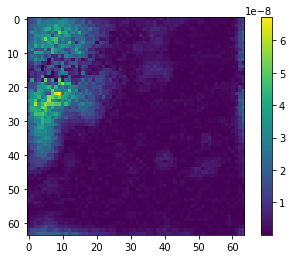

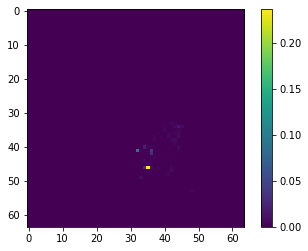

 18%|█▊        | 18/100 [00:12<00:41,  1.98it/s]

1111 8.618172e-07


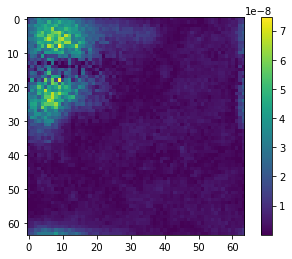

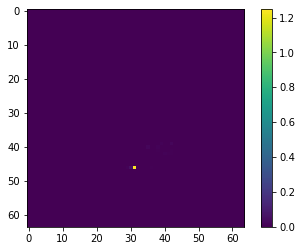

 19%|█▉        | 19/100 [00:13<00:40,  1.99it/s]

1111 7.593724e-07


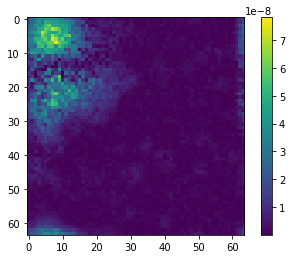

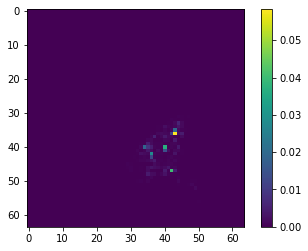

 20%|██        | 20/100 [00:13<00:42,  1.87it/s]

1111 6.85872e-07


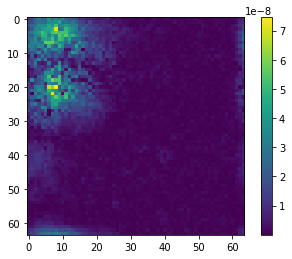

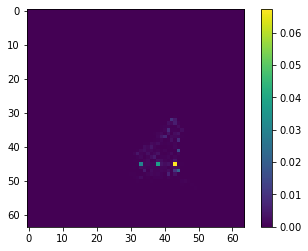

 21%|██        | 21/100 [00:14<00:41,  1.91it/s]

1111 9.251241e-07


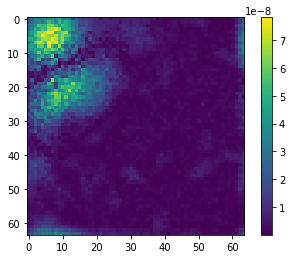

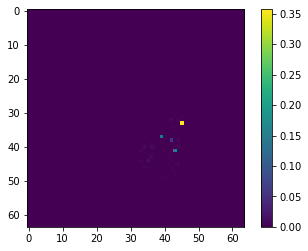

 22%|██▏       | 22/100 [00:14<00:40,  1.94it/s]

1111 8.215203e-07


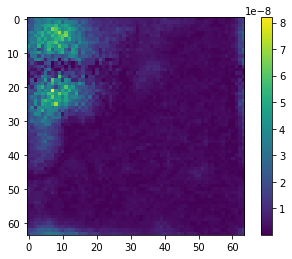

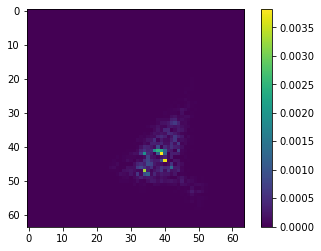

 23%|██▎       | 23/100 [00:15<00:39,  1.95it/s]

1111 1.0181478e-06


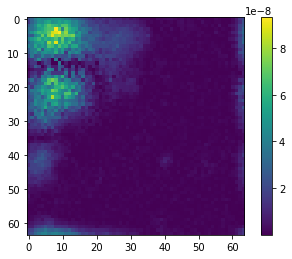

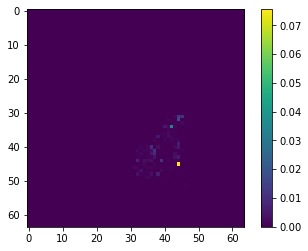

 24%|██▍       | 24/100 [00:15<00:38,  1.97it/s]

1111 8.4653476e-07


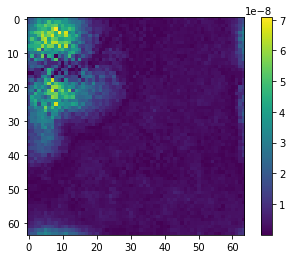

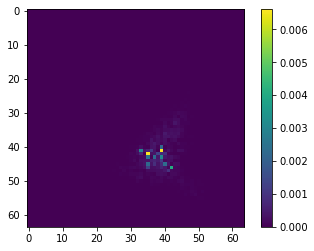

 25%|██▌       | 25/100 [00:16<00:37,  1.99it/s]

1111 7.245745e-07


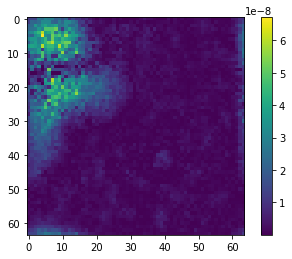

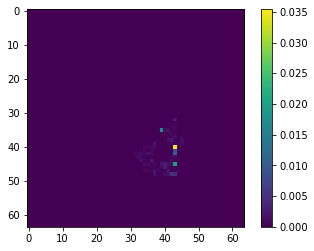

 26%|██▌       | 26/100 [00:16<00:38,  1.90it/s]

1111 8.8395126e-07


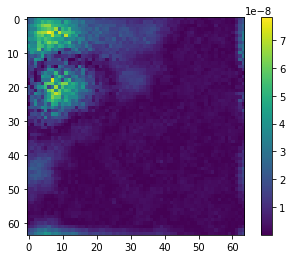

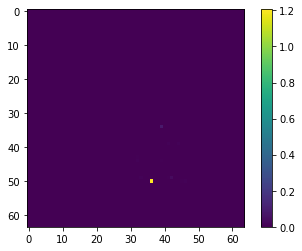

 27%|██▋       | 27/100 [00:17<00:38,  1.91it/s]

1111 6.147765e-07


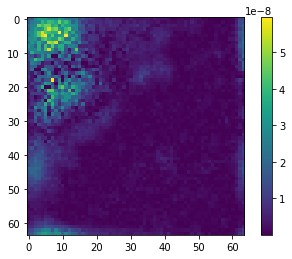

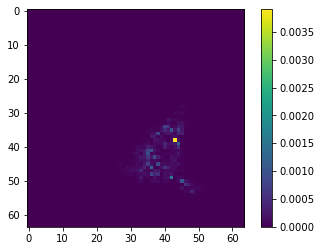

 28%|██▊       | 28/100 [00:18<00:37,  1.93it/s]

1111 7.0595235e-07


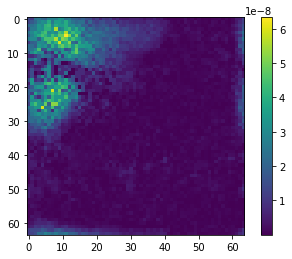

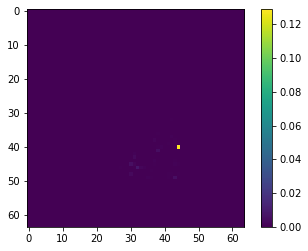

 29%|██▉       | 29/100 [00:18<00:36,  1.94it/s]

1111 9.695179e-07


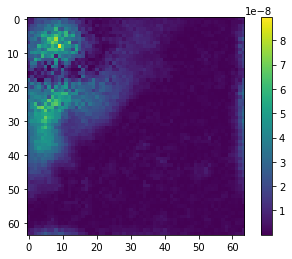

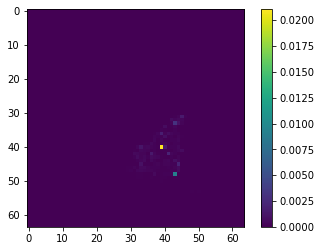

 30%|███       | 30/100 [00:19<00:36,  1.92it/s]

1111 9.76646e-07


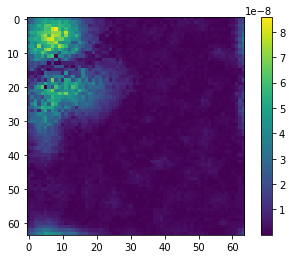

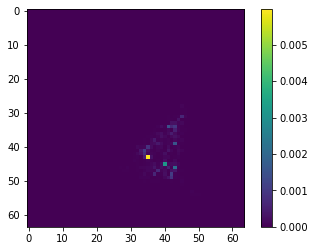

 31%|███       | 31/100 [00:19<00:35,  1.93it/s]

1111 7.3782604e-07


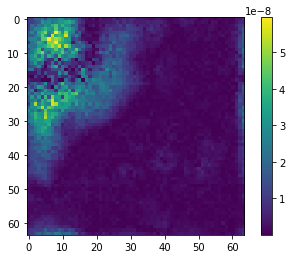

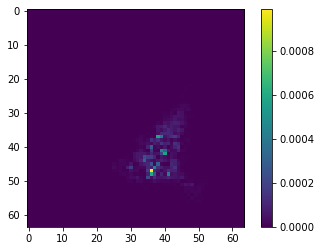

 32%|███▏      | 32/100 [00:20<00:34,  1.96it/s]

1111 8.37996e-07


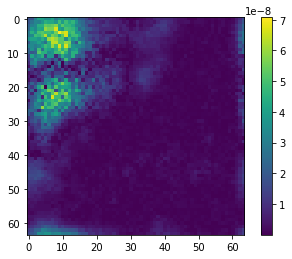

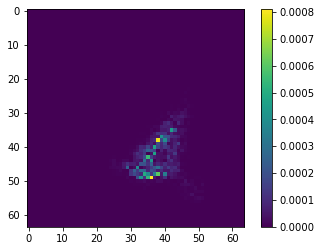

 33%|███▎      | 33/100 [00:20<00:36,  1.83it/s]

1111 7.327238e-07


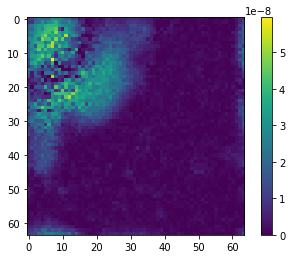

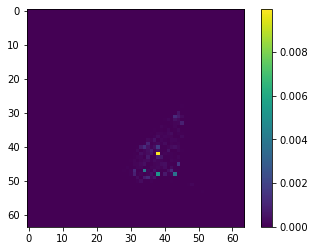

 34%|███▍      | 34/100 [00:21<00:34,  1.89it/s]

1111 8.9052986e-07


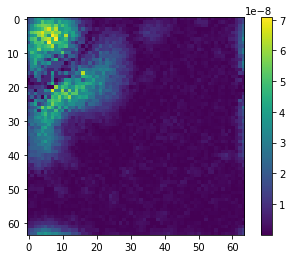

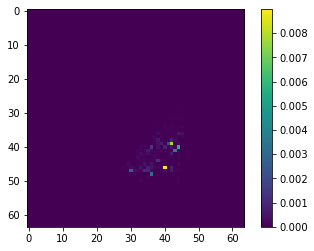

 35%|███▌      | 35/100 [00:21<00:33,  1.92it/s]

1111 8.431995e-07


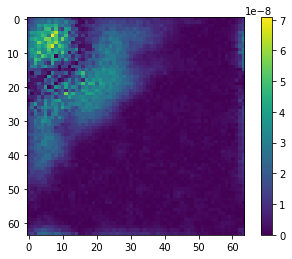

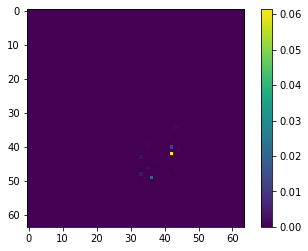

 36%|███▌      | 36/100 [00:22<00:33,  1.94it/s]

1111 7.778884e-07


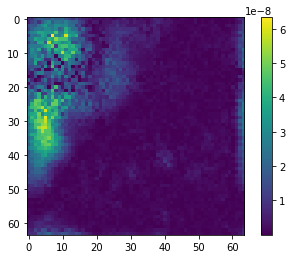

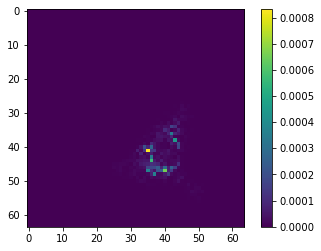

 37%|███▋      | 37/100 [00:22<00:32,  1.95it/s]

1111 6.656387e-07


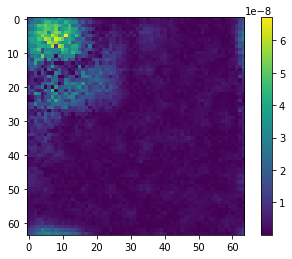

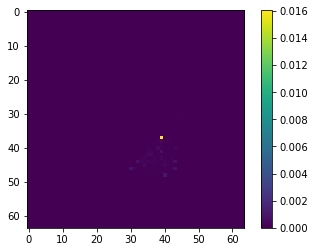

 38%|███▊      | 38/100 [00:23<00:31,  1.96it/s]

1111 6.97459e-07


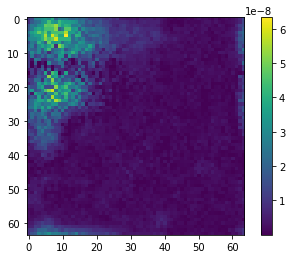

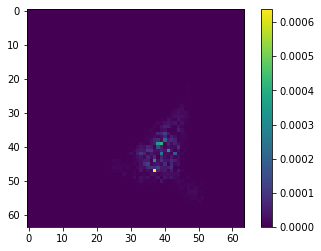

 39%|███▉      | 39/100 [00:23<00:32,  1.87it/s]

1111 9.326346e-07


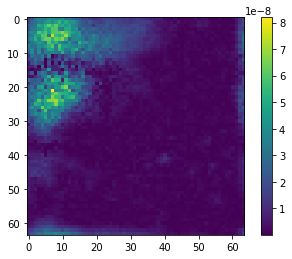

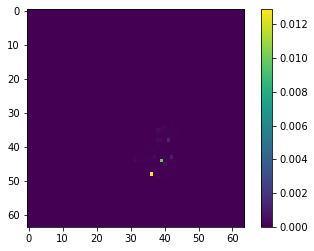

 40%|████      | 40/100 [00:24<00:31,  1.91it/s]

1111 6.981016e-07


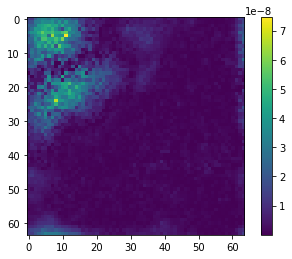

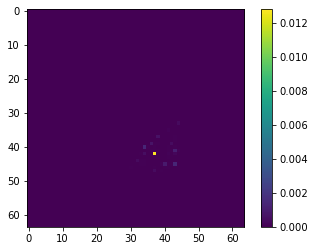

 41%|████      | 41/100 [00:24<00:30,  1.92it/s]

1111 7.9234087e-07


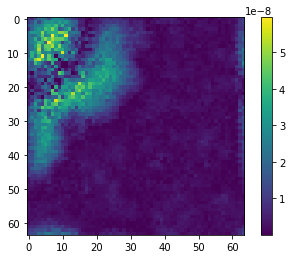

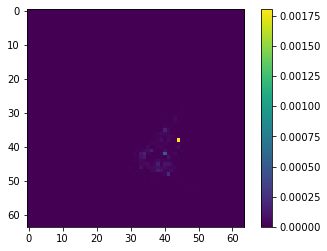

 42%|████▏     | 42/100 [00:25<00:29,  1.95it/s]

1111 9.0410543e-07


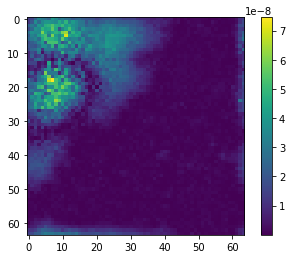

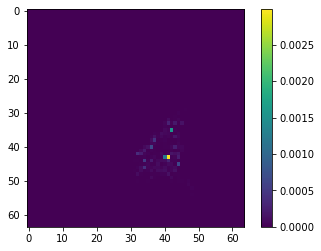

 43%|████▎     | 43/100 [00:25<00:28,  1.97it/s]

1111 6.346118e-07


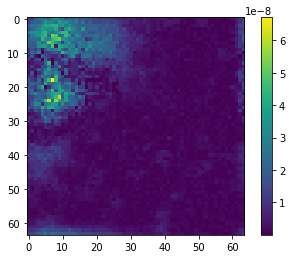

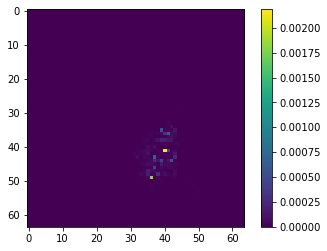

 44%|████▍     | 44/100 [00:26<00:28,  1.97it/s]

1111 7.0476875e-07


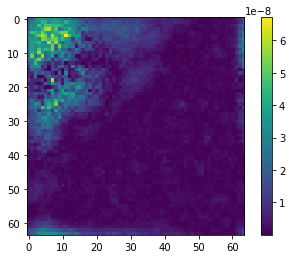

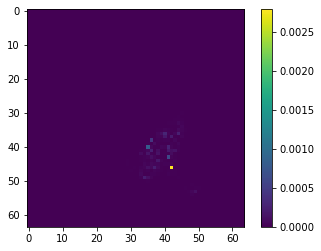

 45%|████▌     | 45/100 [00:26<00:29,  1.89it/s]

nmse0 reach 1e-4 accuracy in 44 iterations and 27.008877351880074 time
1111 7.619104e-07


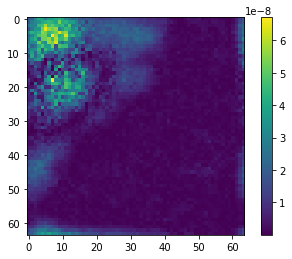

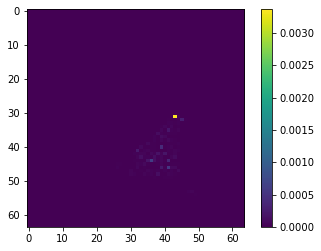

 46%|████▌     | 46/100 [00:27<00:28,  1.92it/s]

1111 7.337065e-07


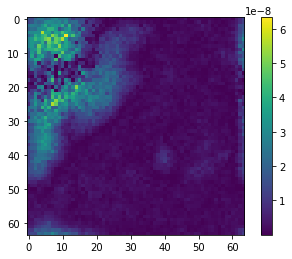

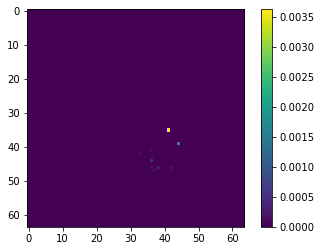

 47%|████▋     | 47/100 [00:27<00:27,  1.94it/s]

1111 7.509927e-07


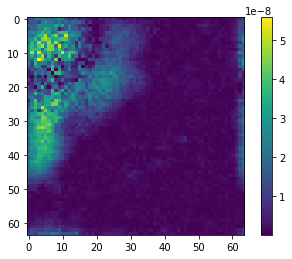

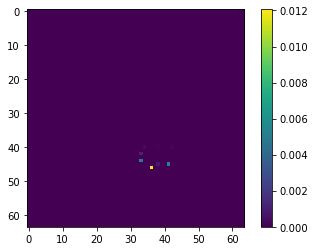

 48%|████▊     | 48/100 [00:28<00:26,  1.97it/s]

1111 1.0128277e-06


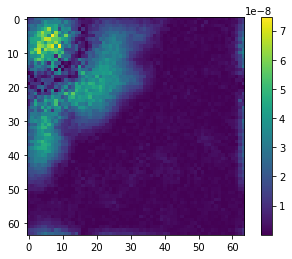

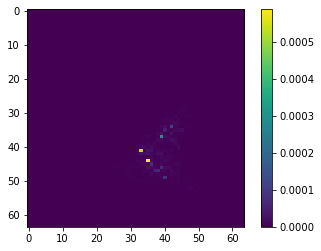

 49%|████▉     | 49/100 [00:28<00:25,  1.98it/s]

1111 9.2253015e-07


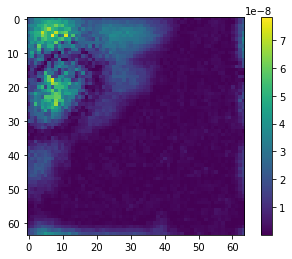

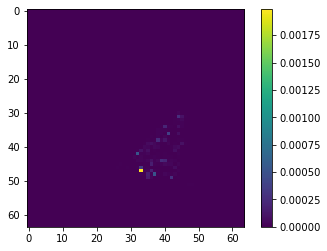

 50%|█████     | 50/100 [00:29<00:25,  1.98it/s]

1111 6.903546e-07


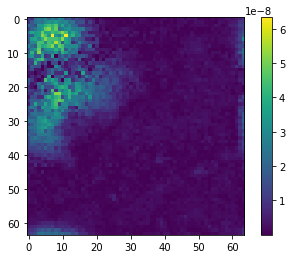

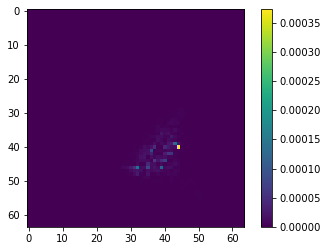

 51%|█████     | 51/100 [00:29<00:24,  1.99it/s]

1111 6.1325915e-07


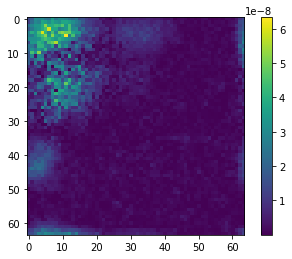

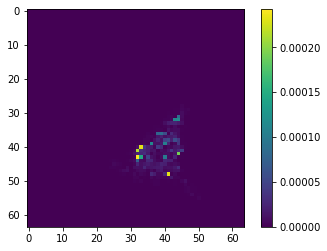

 52%|█████▏    | 52/100 [00:30<00:25,  1.91it/s]

1111 8.292649e-07


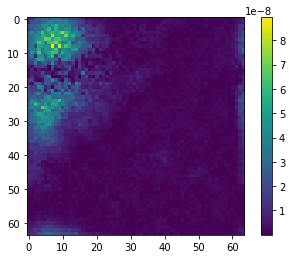

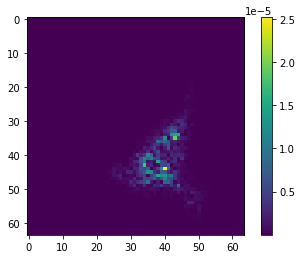

 53%|█████▎    | 53/100 [00:30<00:24,  1.94it/s]

1111 7.317675e-07


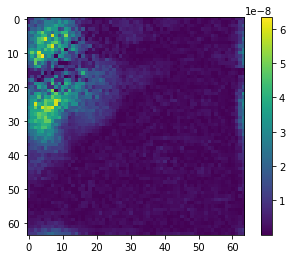

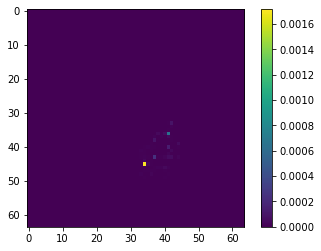

 54%|█████▍    | 54/100 [00:31<00:23,  1.96it/s]

1111 7.905652e-07


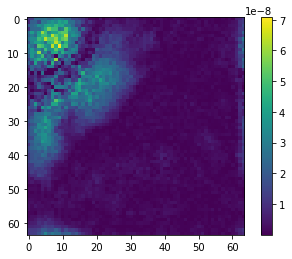

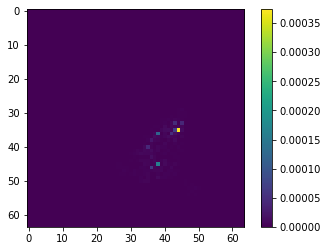

 55%|█████▌    | 55/100 [00:31<00:22,  1.97it/s]

1111 6.868856e-07


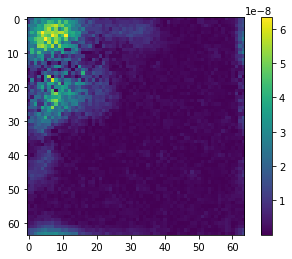

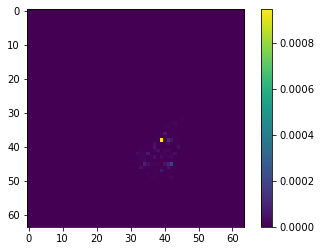

 56%|█████▌    | 56/100 [00:32<00:22,  1.99it/s]

1111 7.8281965e-07


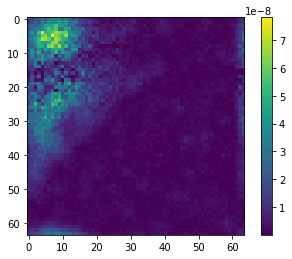

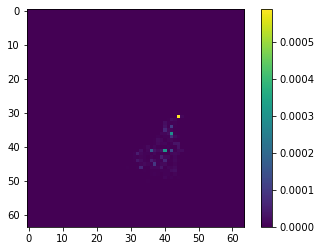

 57%|█████▋    | 57/100 [00:32<00:21,  2.00it/s]

1111 8.239427e-07


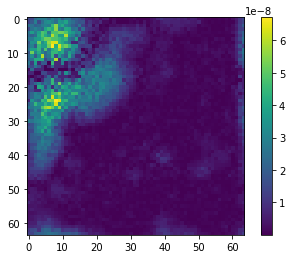

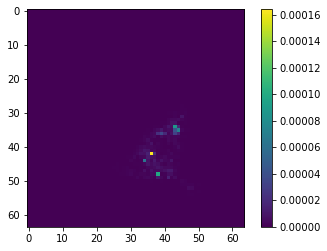

 58%|█████▊    | 58/100 [00:33<00:22,  1.91it/s]

1111 7.54328e-07


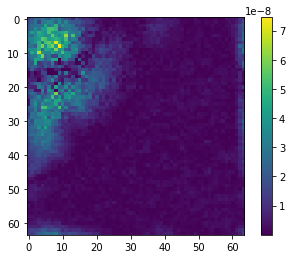

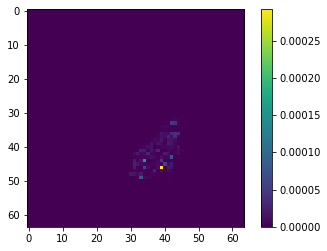

 59%|█████▉    | 59/100 [00:33<00:21,  1.94it/s]

1111 8.898485e-07


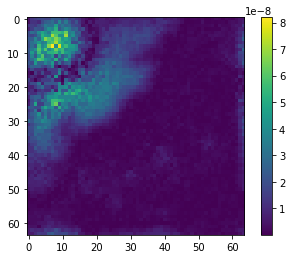

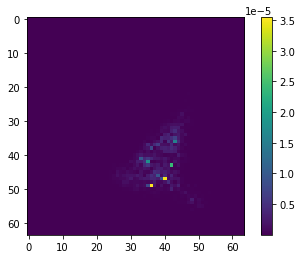

 60%|██████    | 60/100 [00:34<00:20,  1.95it/s]

1111 9.250981e-07


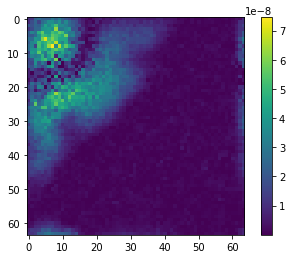

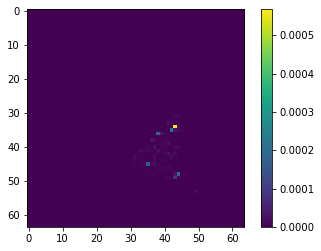

 61%|██████    | 61/100 [00:34<00:19,  1.97it/s]

1111 7.559912e-07


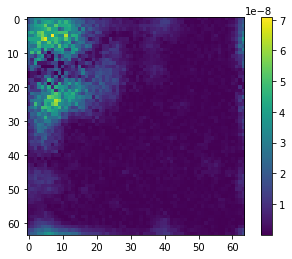

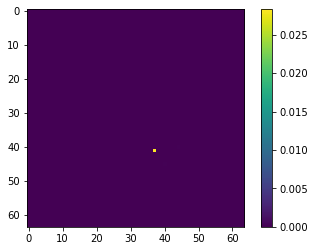

 62%|██████▏   | 62/100 [00:35<00:19,  1.99it/s]

1111 8.03736e-07


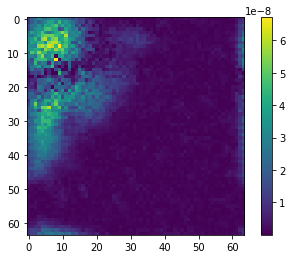

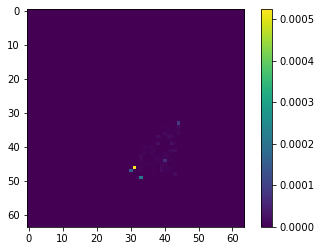

 63%|██████▎   | 63/100 [00:35<00:18,  2.01it/s]

1111 8.1797094e-07


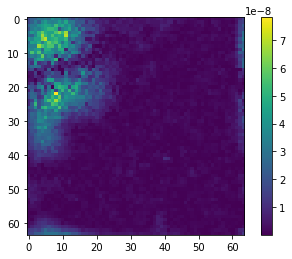

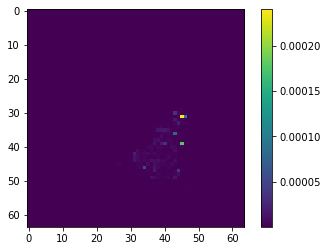

 64%|██████▍   | 64/100 [00:36<00:17,  2.02it/s]

1111 9.3949944e-07


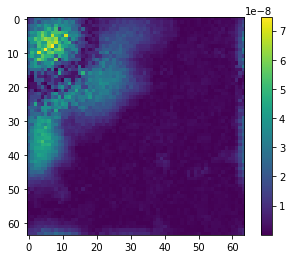

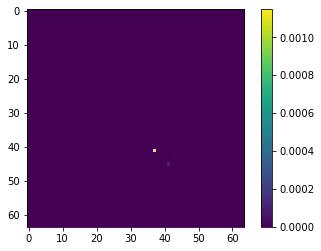

 65%|██████▌   | 65/100 [00:37<00:18,  1.92it/s]

1111 7.289524e-07


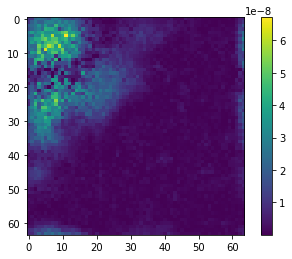

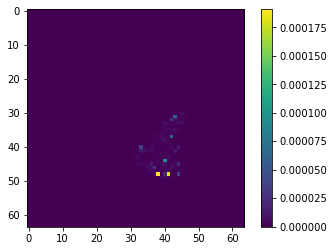

 66%|██████▌   | 66/100 [00:37<00:17,  1.94it/s]

1111 6.7827693e-07


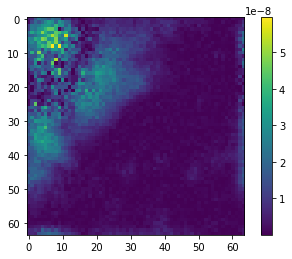

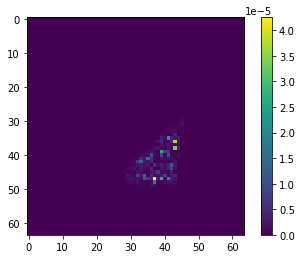

 67%|██████▋   | 67/100 [00:38<00:16,  1.96it/s]

1111 8.210897e-07


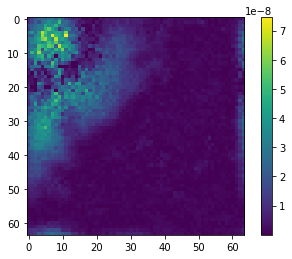

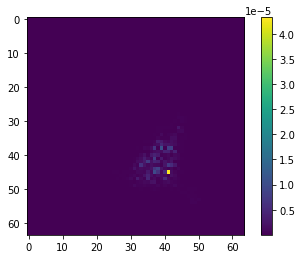

 68%|██████▊   | 68/100 [00:38<00:16,  1.97it/s]

1111 7.0764463e-07


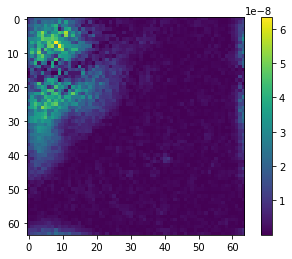

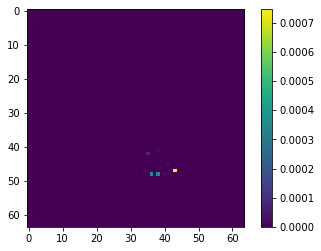

 69%|██████▉   | 69/100 [00:39<00:15,  1.98it/s]

1111 8.8394876e-07


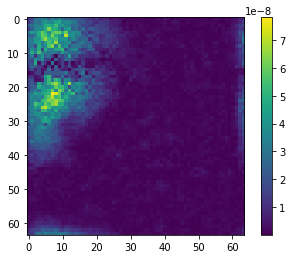

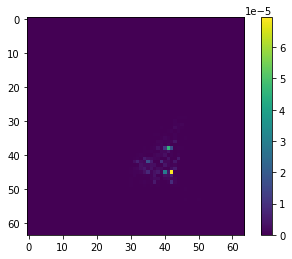

 70%|███████   | 70/100 [00:39<00:15,  1.99it/s]

1111 8.1071096e-07


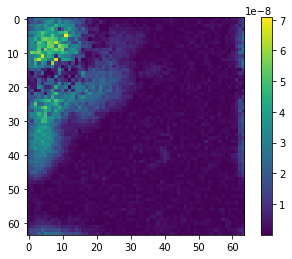

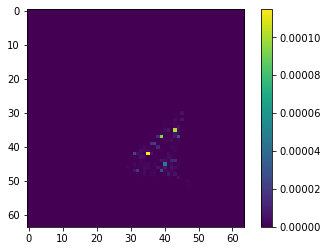

 71%|███████   | 71/100 [00:40<00:15,  1.91it/s]

1111 7.530492e-07


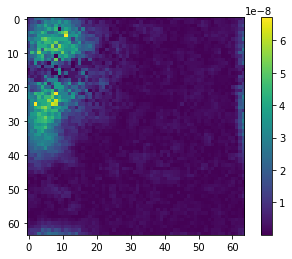

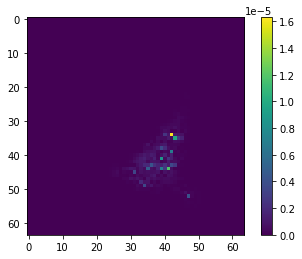

 72%|███████▏  | 72/100 [00:40<00:14,  1.93it/s]

1111 8.1473434e-07


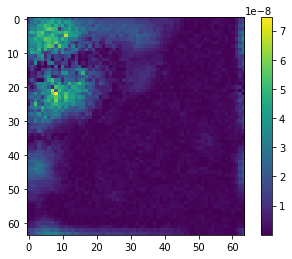

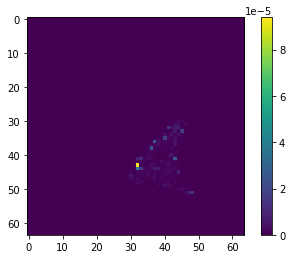

 73%|███████▎  | 73/100 [00:41<00:13,  1.96it/s]

1111 9.125744e-07


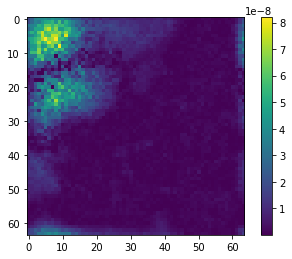

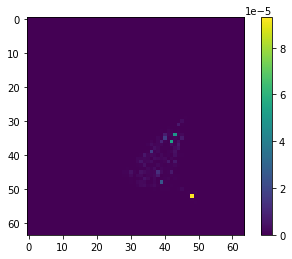

 74%|███████▍  | 74/100 [00:41<00:13,  1.98it/s]

1111 8.956179e-07


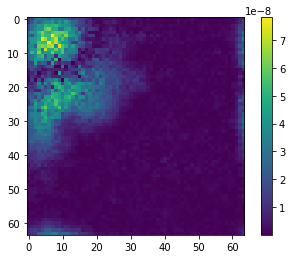

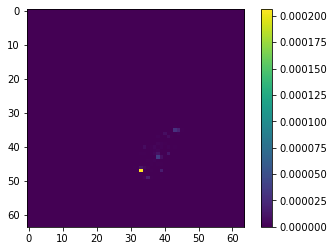

 75%|███████▌  | 75/100 [00:42<00:12,  1.98it/s]

1111 9.64147e-07


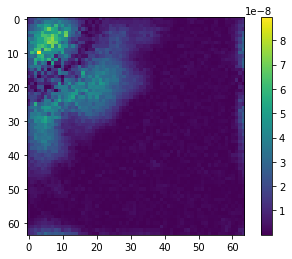

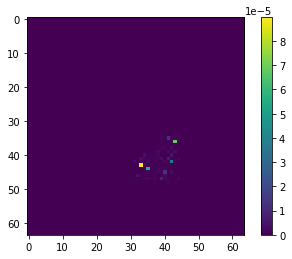

 76%|███████▌  | 76/100 [00:42<00:12,  1.97it/s]

1111 9.3254505e-07


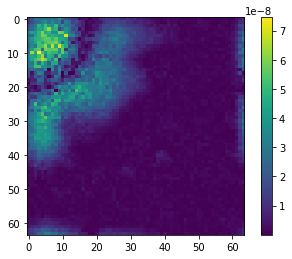

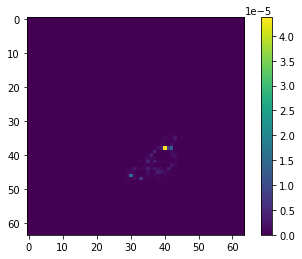

 77%|███████▋  | 77/100 [00:43<00:12,  1.89it/s]

1111 9.378761e-07


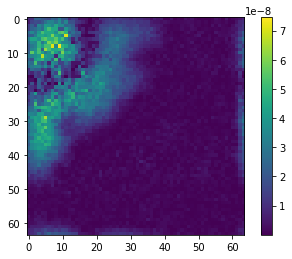

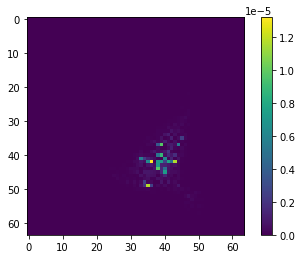

 78%|███████▊  | 78/100 [00:43<00:11,  1.92it/s]

1111 1.0092235e-06


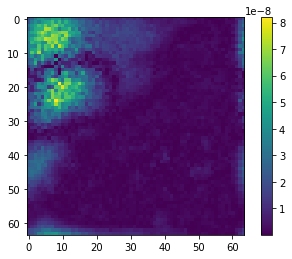

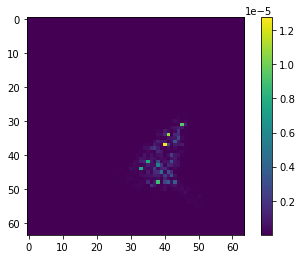

 79%|███████▉  | 79/100 [00:44<00:10,  1.94it/s]

1111 8.6596003e-07


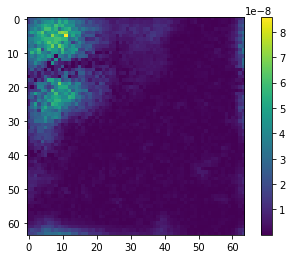

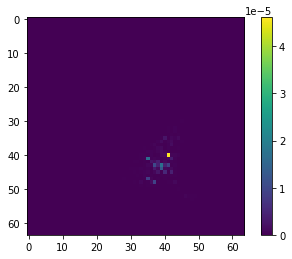

 80%|████████  | 80/100 [00:44<00:10,  1.96it/s]

1111 8.8383945e-07


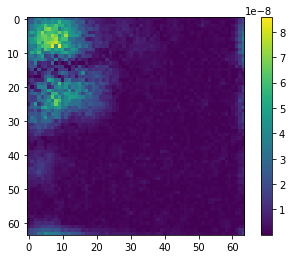

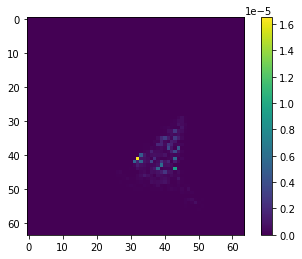

 81%|████████  | 81/100 [00:45<00:09,  1.96it/s]

1111 8.475604e-07


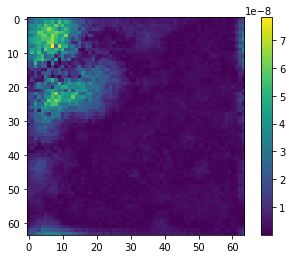

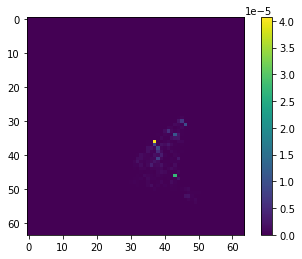

 82%|████████▏ | 82/100 [00:45<00:09,  1.97it/s]

1111 9.898891e-07


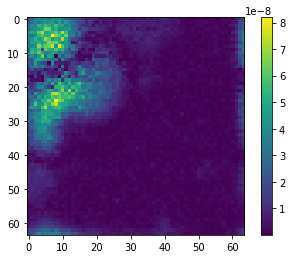

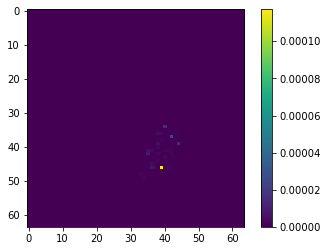

 83%|████████▎ | 83/100 [00:46<00:08,  1.98it/s]

1111 8.627343e-07


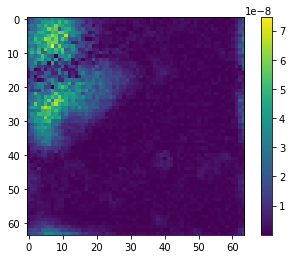

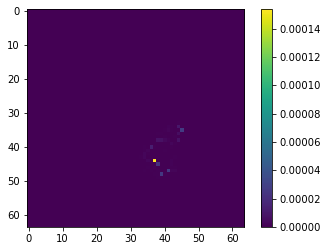

 84%|████████▍ | 84/100 [00:46<00:08,  1.89it/s]

1111 9.182049e-07


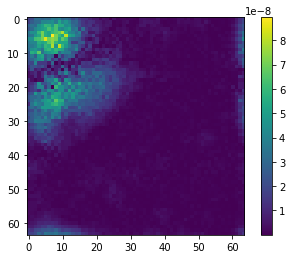

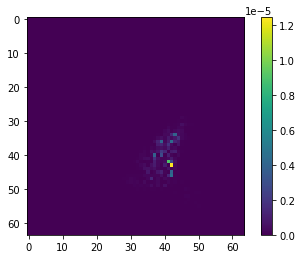

 85%|████████▌ | 85/100 [00:47<00:07,  1.88it/s]

1111 8.695431e-07


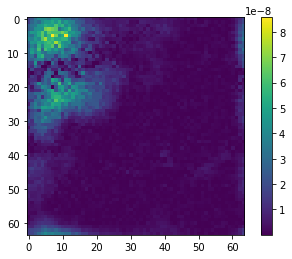

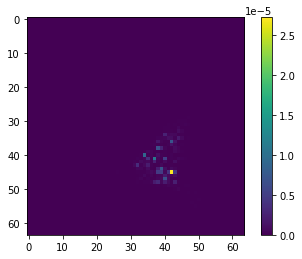

 86%|████████▌ | 86/100 [00:47<00:07,  1.90it/s]

1111 7.549251e-07


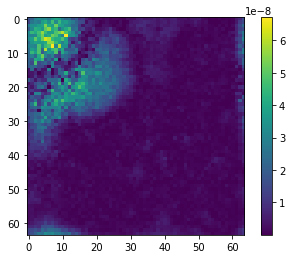

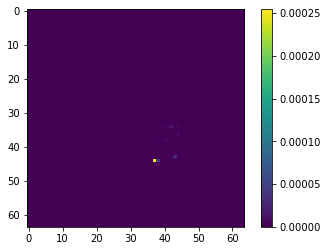

 87%|████████▋ | 87/100 [00:48<00:06,  1.93it/s]

1111 9.6111e-07


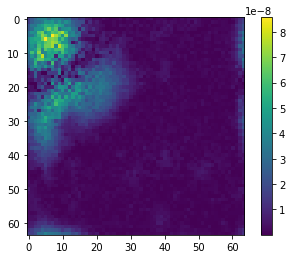

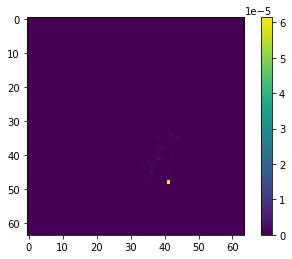

 88%|████████▊ | 88/100 [00:48<00:06,  1.95it/s]

1111 9.39493e-07


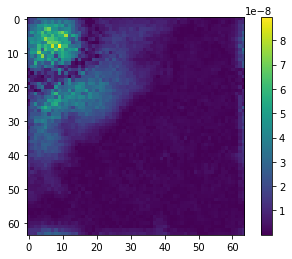

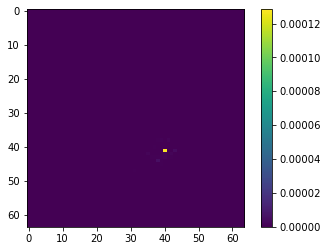

 89%|████████▉ | 89/100 [00:49<00:05,  1.97it/s]

1111 7.477917e-07


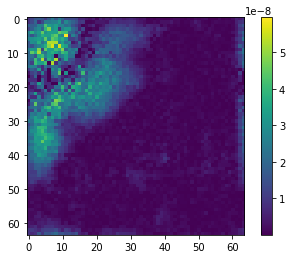

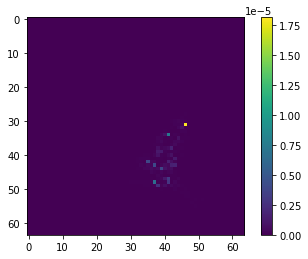

 90%|█████████ | 90/100 [00:49<00:05,  1.90it/s]

1111 8.2027134e-07


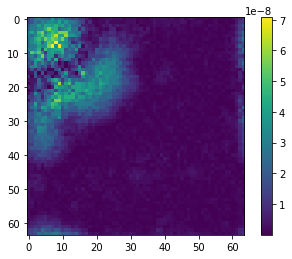

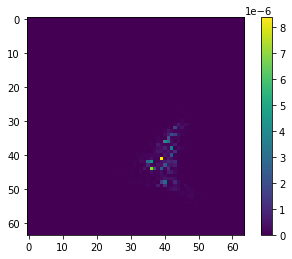

 91%|█████████ | 91/100 [00:50<00:04,  1.93it/s]

1111 9.111567e-07


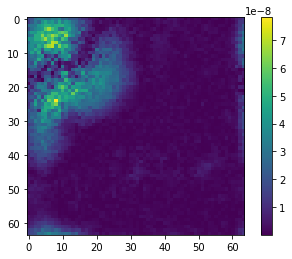

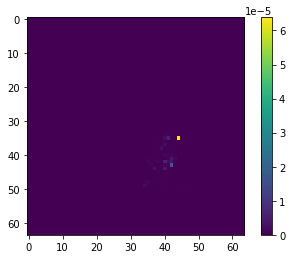

 92%|█████████▏| 92/100 [00:50<00:04,  1.95it/s]

1111 7.8690147e-07


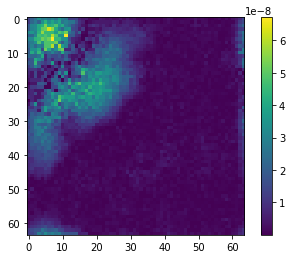

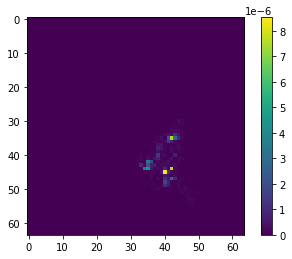

 93%|█████████▎| 93/100 [00:51<00:03,  1.97it/s]

1111 8.7401935e-07


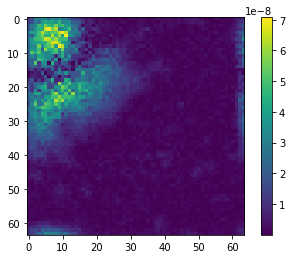

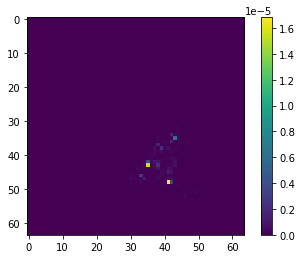

 94%|█████████▍| 94/100 [00:51<00:03,  1.97it/s]

1111 9.482097e-07


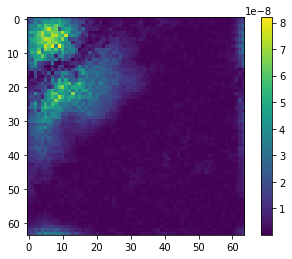

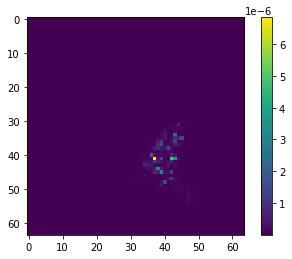

 95%|█████████▌| 95/100 [00:52<00:02,  1.98it/s]

1111 8.2079174e-07


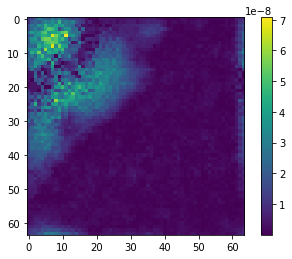

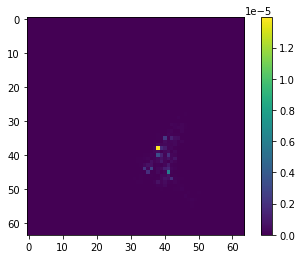

 96%|█████████▌| 96/100 [00:52<00:02,  1.99it/s]

1111 8.007202e-07


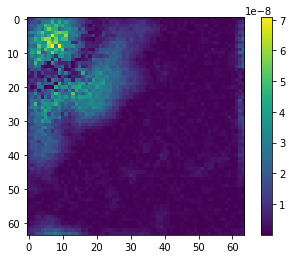

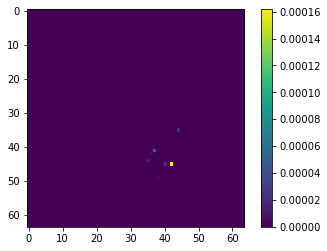

 97%|█████████▋| 97/100 [00:53<00:01,  1.90it/s]

1111 7.6586247e-07


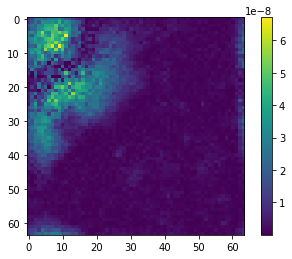

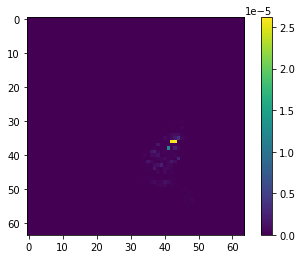

 98%|█████████▊| 98/100 [00:54<00:01,  1.93it/s]

1111 8.7192825e-07


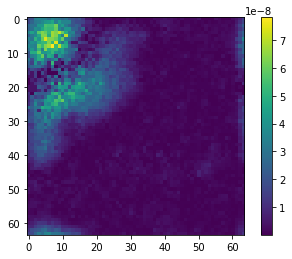

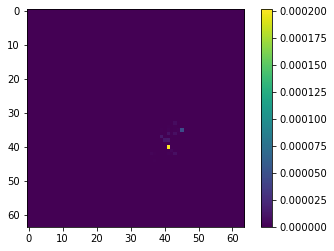

 99%|█████████▉| 99/100 [00:54<00:00,  1.95it/s]

1111 9.781968e-07


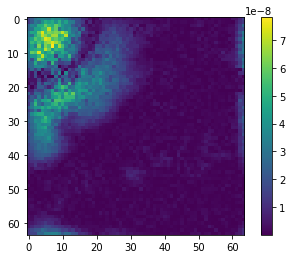

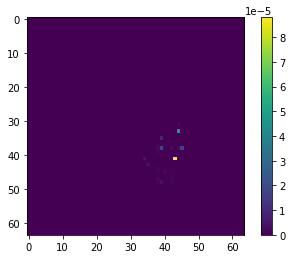

100%|██████████| 100/100 [00:55<00:00,  1.82it/s]

end of loop, memory used, and total/1e9: 0.04263936 0.458135552
normalized by data.nbytes memory used and total normalized: 10.166015625 109.22802734375
----
total time: 55.152687123045325
{'Overlap': 0, 'Split': 0, 'Prox_data': 0.007485537324100733, 'Data_prox_tot': 0.4845044696703553, 'Propagate': 0.4530535778030753, 'mse_data': 0.02373134344816208, 'Gramiam': 9.667500853538513e-05, 'Gramiam_completion': 0.00021672062575817108, 'Precondition': 0, 'Eigensolver': 35.87495679408312, 'Sync_setup': 5.3273048251867294e-05, 'fd': 0}
total time operators benchmarked: 36.84409839101136
after normalization


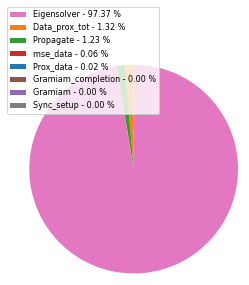

solver timers:
 {'solver_tot': 55.15161594701931, 'solver_loop': 55.01822127494961, 'ProxD': 0.4890346247702837, 'Overlap': 0.025318605359643698, 'Sync': 54.35040843533352, 'illuminate&split': 0.009918495547026396, 'refine_illumination': 8.346233516931534e-05, 'mse_step': 0.022519292309880257, 'mse_truth': 0.05951470322906971, 'copies': 0.00670052831992507, 'loop_intrnl': 54.96404049685225, 'solver_final': 0.007315929047763348, 'solver_init': 0.12607411807402968}
solver timers after normalization by 55.01822127494961 :
 {'solver_tot': 1.002424554429033, 'solver_loop': 1.0, 'ProxD': 0.008888593877405964, 'Overlap': 0.0004601858215865574, 'Sync': 0.9878619696504046, 'illuminate&split': 0.00018027655778727245, 'refine_illumination': 1.5169944290313987e-06, 'mse_step': 0.00040930607693298024, 'mse_truth': 0.001081727141480079, 'copies': 0.00012178743995447727, 'loop_intrnl': 0.9990152211968722, 'solver_final': 0.0001329728384202484, 'solver_init': 0.0022914975285003004}
mse timings: 0.0252

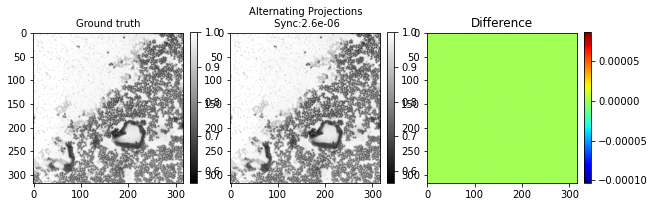

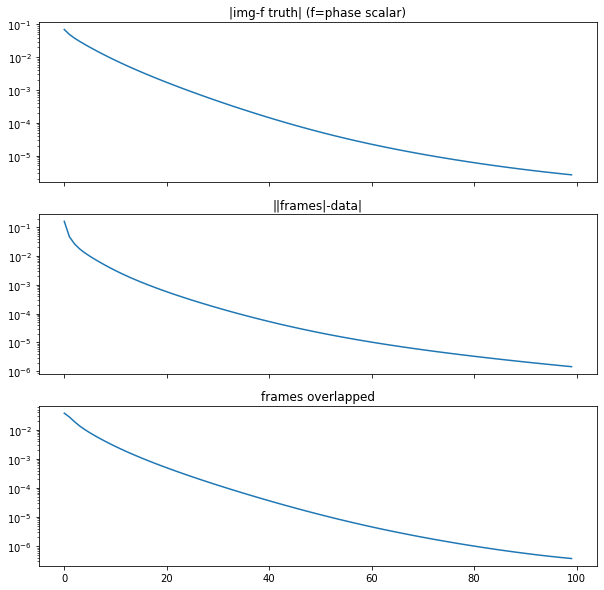

solver tot (seconds) : 55.15161594701931 loop: 55.01822127494961 seconds
proxD : 0.8888593877405964 %
Overlap : 0.046018582158655744 %
illuminate and split : 0.018027655778727246 %
mse: 0.1922369290322153 %
proxD (propagate(ffts), mse, prox)%: (93.5086477347302, 4.898064916575133, 1.5449882906536867)


In [1]:
fname_in = "poster_64x64.h5"
%run -i ptycho_reconstruct.py

In [5]:
xp.abs(xp.array([-1-1j,-1-1j]))

array([1.41421356, 1.41421356])

using GPU
loaded data, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
Split and Overlap, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
geometry: img size: (317, 317) frames: (16, 16, 4096)
not refining illumination, starting with good one, maxiter: 20
start AP memory used, and total: 16533504 458135552
normalized by data.nbytes memory used and total normalized: 3.94189453125 109.22802734375
data size 4194304
----
after Prox_data, memory used, and total: 16567296 458135552
normalized by data.nbytes memory used and total normalized: 3.949951171875 109.22802734375
----
after frames initial, memory used, and total: 24955904 458135552
normalized by data.nbytes memory used and total normalized: 5.949951171875 109.22802734375
----
start loop, memory used, and total: 34182656 45813555

  0%|          | 0/20 [00:00<?, ?it/s]

1111 0.64498365
0.64498365
0.64498365
HELLO 4.5934185e-12


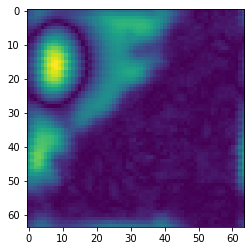

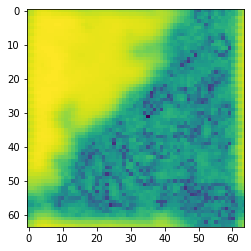

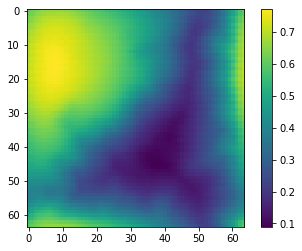

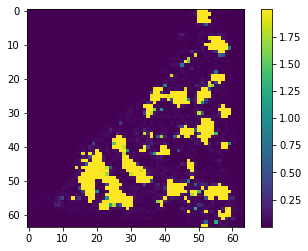

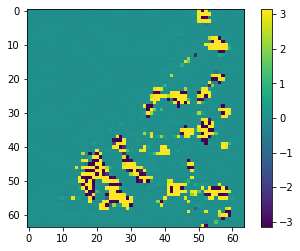

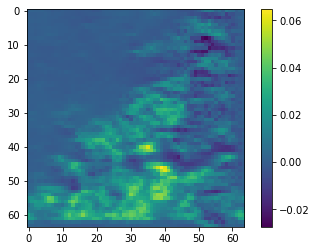

  5%|▌         | 1/20 [00:01<00:35,  1.89s/it]

1111 0.66241723
0.66241723
0.66241723
HELLO 3.5885697e-10


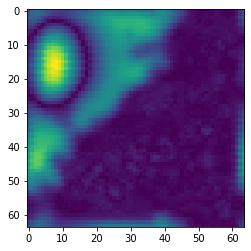

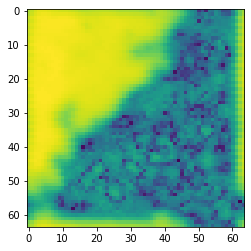

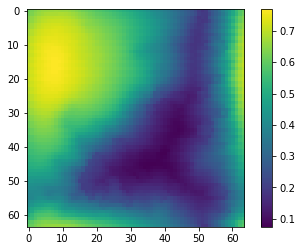

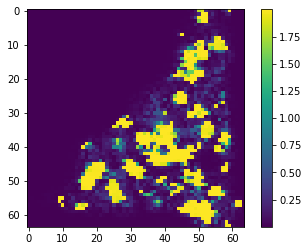

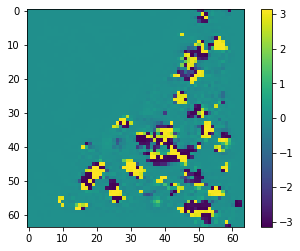

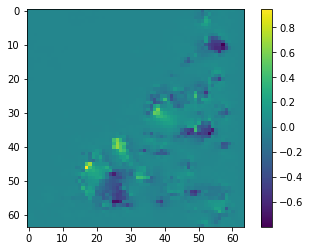

 10%|█         | 2/20 [00:02<00:24,  1.35s/it]

1111 0.6622296
0.6622296
0.6622296
HELLO -5.451894e-10


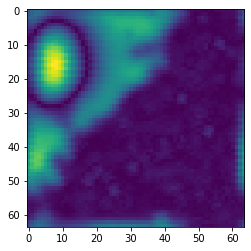

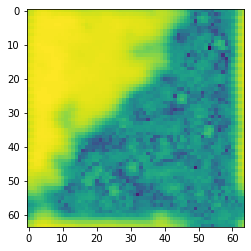

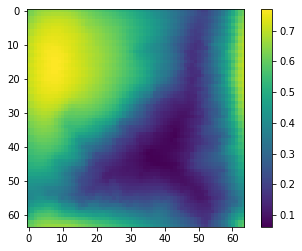

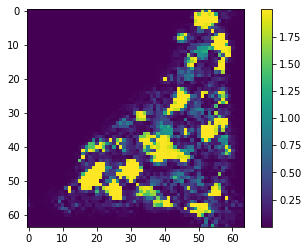

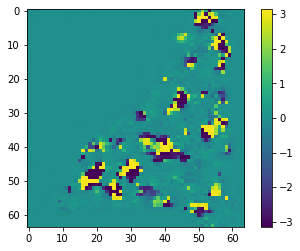

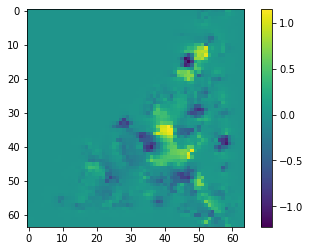

 15%|█▌        | 3/20 [00:03<00:20,  1.20s/it]

1111 0.66092825
0.66092825
0.66092825
HELLO -1.6291116e-10


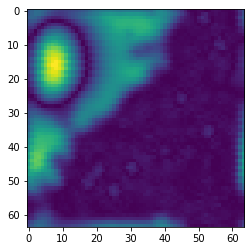

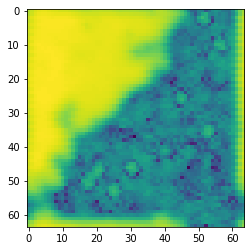

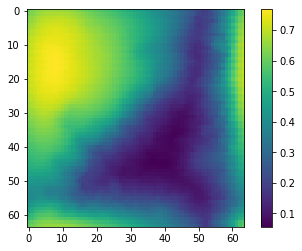

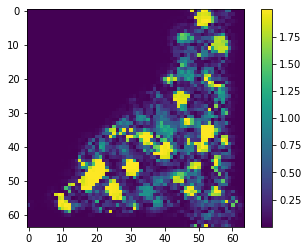

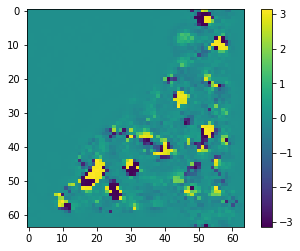

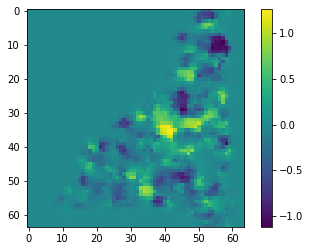

 20%|██        | 4/20 [00:04<00:17,  1.11s/it]

1111 0.6621368
0.6621368
0.6621368
HELLO 5.591245e-11


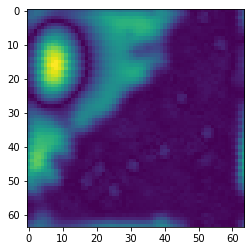

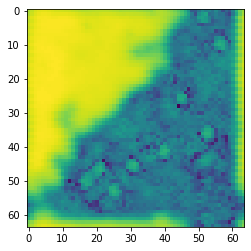

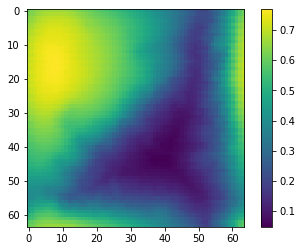

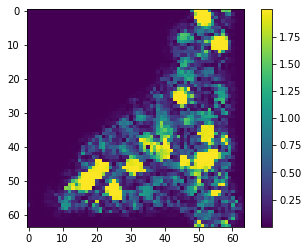

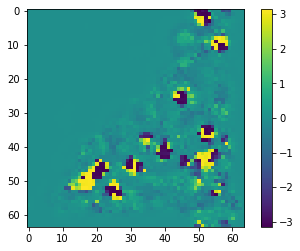

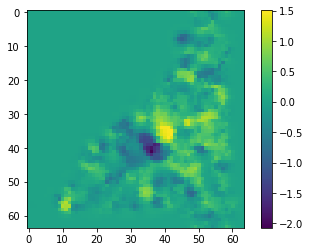

 25%|██▌       | 5/20 [00:05<00:15,  1.06s/it]

1111 0.66080576
0.66080576
0.66080576
HELLO -3.8629225e-10


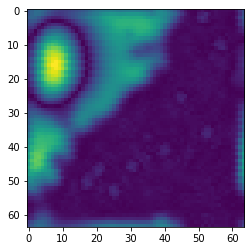

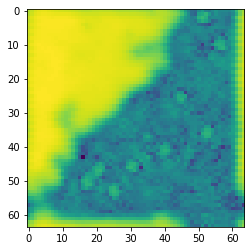

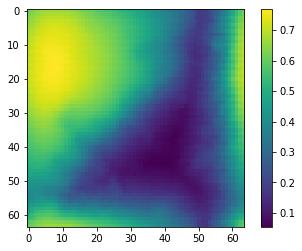

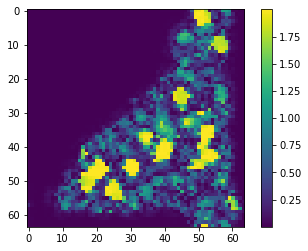

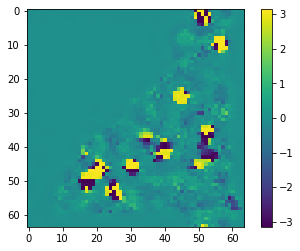

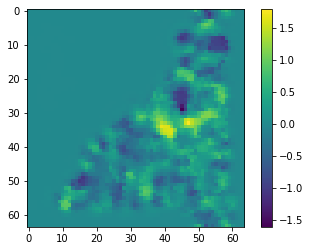

 30%|███       | 6/20 [00:06<00:14,  1.05s/it]

1111 0.66093916
0.66093916
0.66093916
HELLO 3.4909867e-10


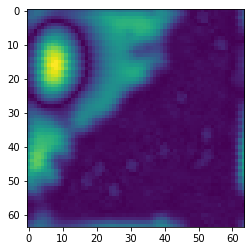

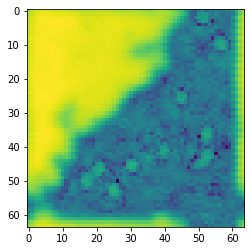

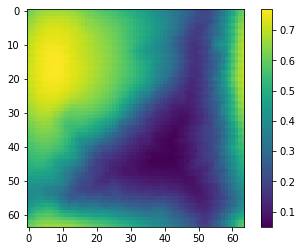

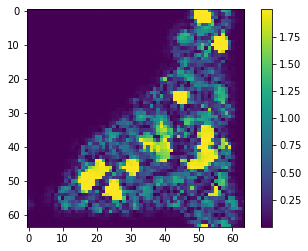

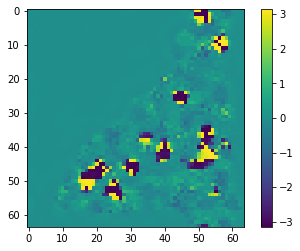

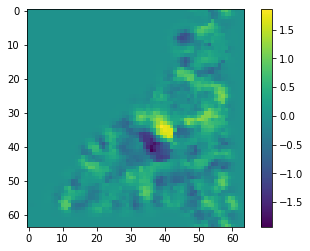

 35%|███▌      | 7/20 [00:07<00:13,  1.03s/it]

1111 0.6605041
0.6605041
0.6605041
HELLO 1.1399696e-10


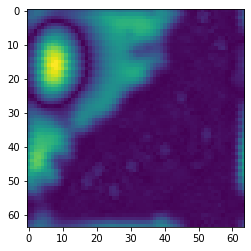

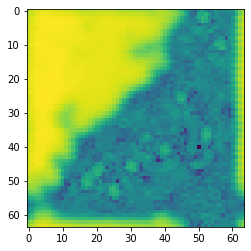

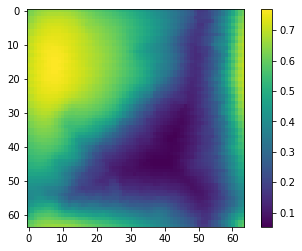

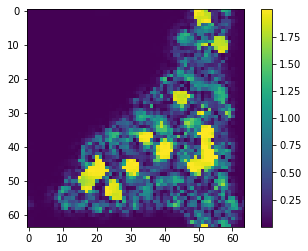

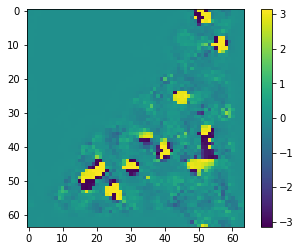

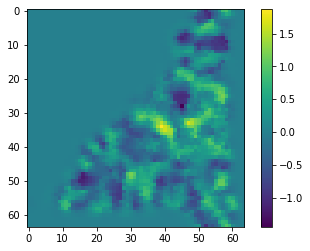

 40%|████      | 8/20 [00:08<00:12,  1.03s/it]

1111 0.6608225
0.6608225
0.6608225
HELLO -4.5611048e-10


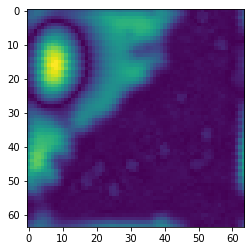

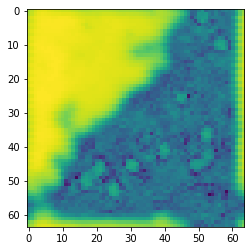

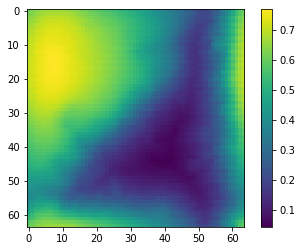

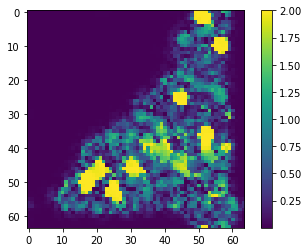

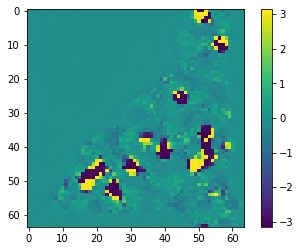

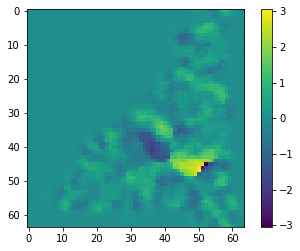

 45%|████▌     | 9/20 [00:09<00:11,  1.01s/it]

1111 0.6604033
0.6604033
0.6604033
HELLO -3.6987696e-10


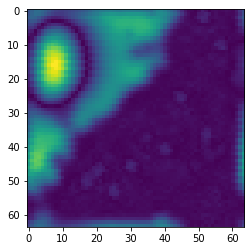

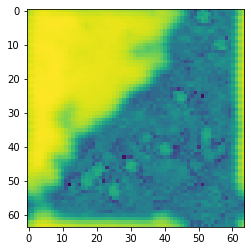

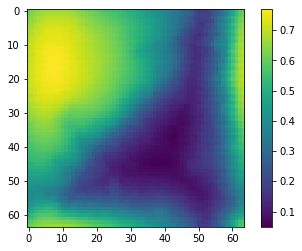

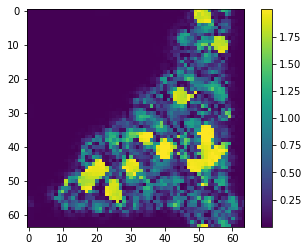

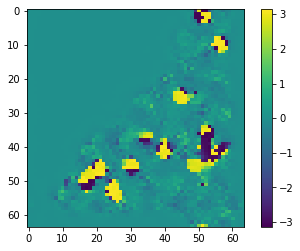

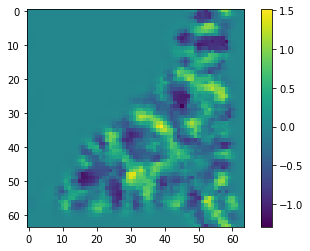

 50%|█████     | 10/20 [00:10<00:09,  1.00it/s]

1111 0.66121835
0.66121835
0.66121835
HELLO -1.8390203e-10


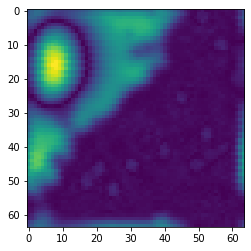

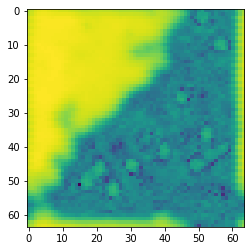

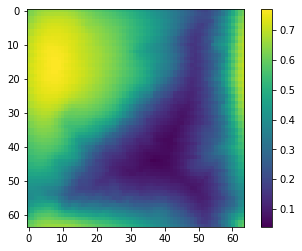

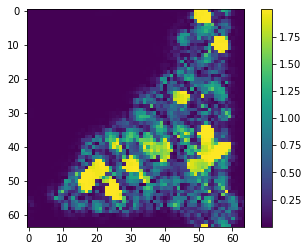

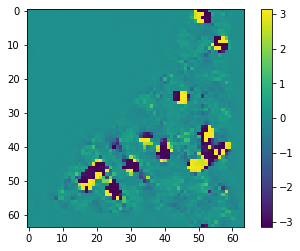

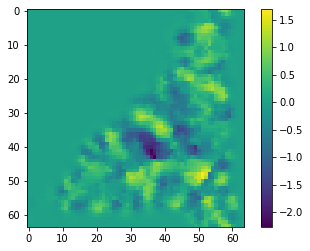

 55%|█████▌    | 11/20 [00:11<00:09,  1.02s/it]

1111 0.6610085
0.6610085
0.6610085
HELLO 3.9799578e-10


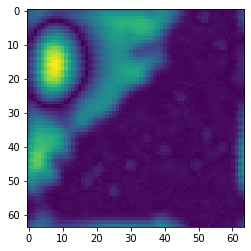

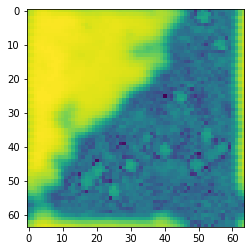

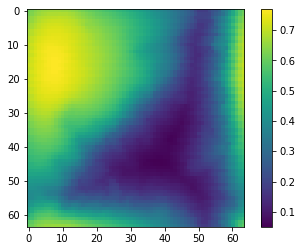

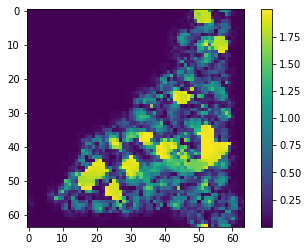

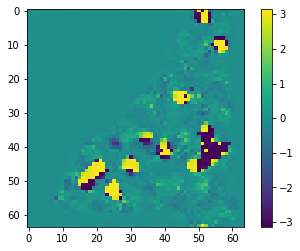

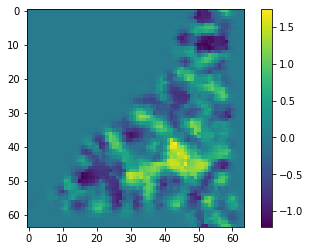

 60%|██████    | 12/20 [00:12<00:07,  1.00it/s]

1111 0.66077757
0.66077757
0.66077757
HELLO -6.806492e-10


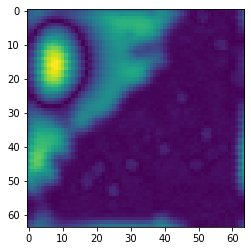

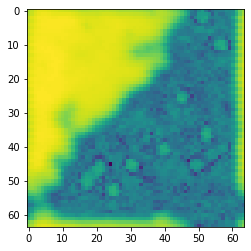

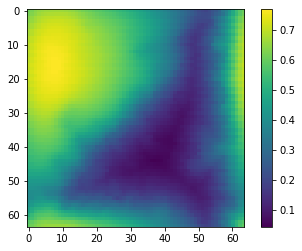

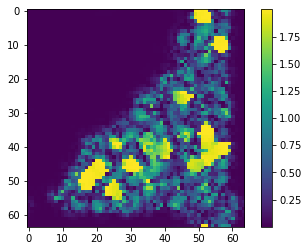

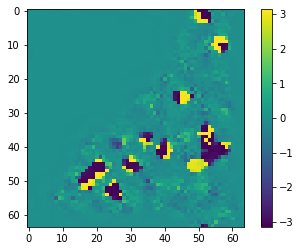

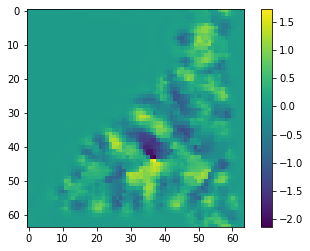

 65%|██████▌   | 13/20 [00:13<00:07,  1.01s/it]

1111 0.6611181
0.6611181
0.6611181
HELLO -6.983028e-11


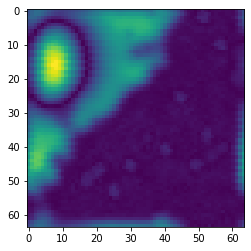

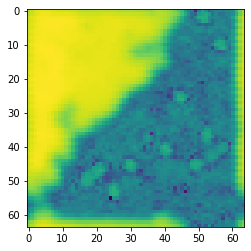

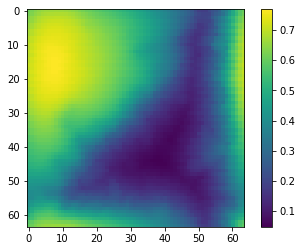

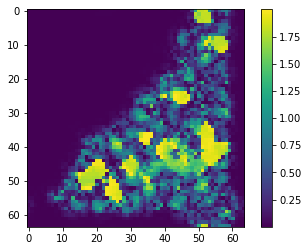

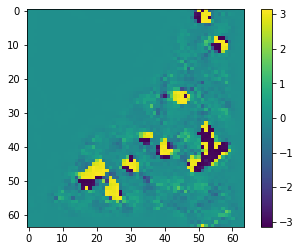

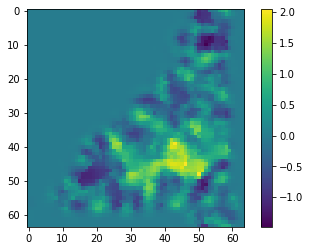

 70%|███████   | 14/20 [00:14<00:06,  1.02s/it]

1111 0.6610746
0.6610746
0.6610746
HELLO 5.2370795e-11


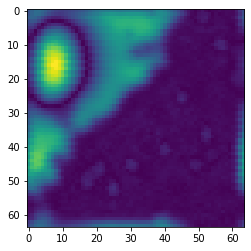

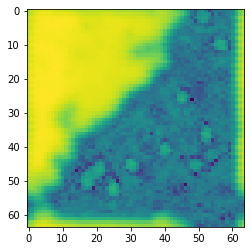

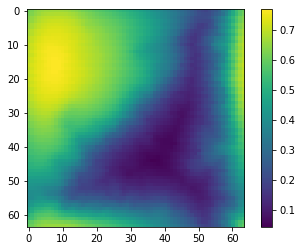

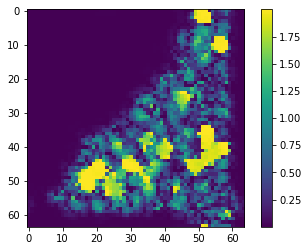

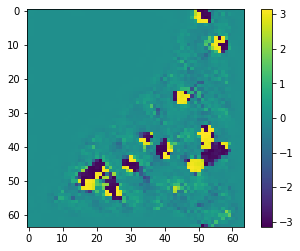

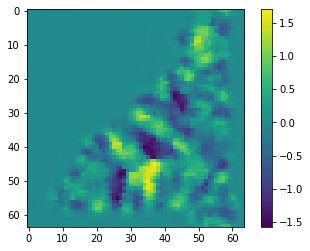

 75%|███████▌  | 15/20 [00:15<00:05,  1.04s/it]

1111 0.66146463
0.66146463
0.66146463
HELLO -8.3820936e-11


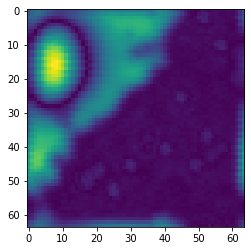

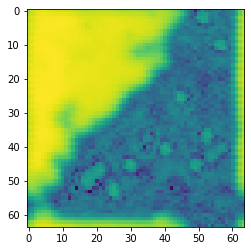

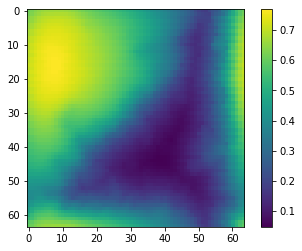

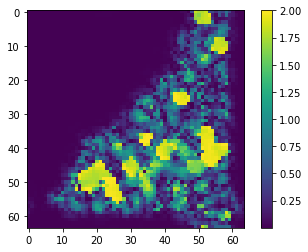

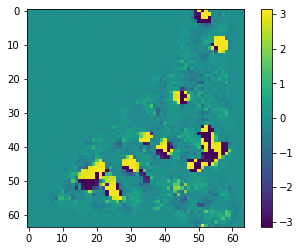

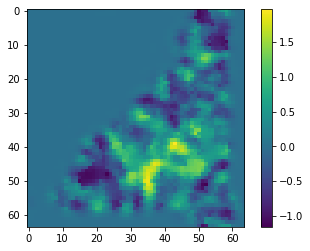

 80%|████████  | 16/20 [00:16<00:04,  1.01s/it]

1111 0.6614692
0.6614692
0.6614692
HELLO 1.5367231e-10


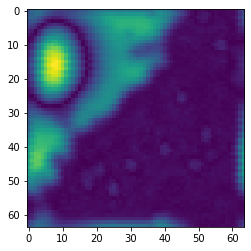

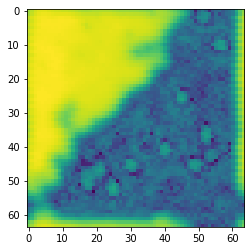

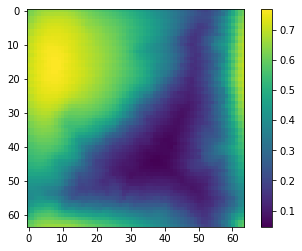

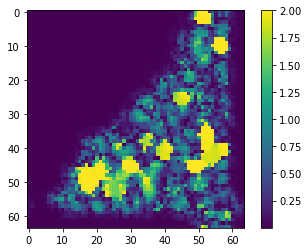

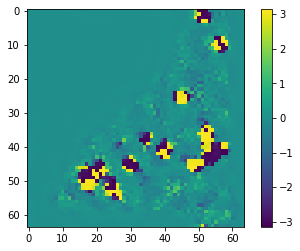

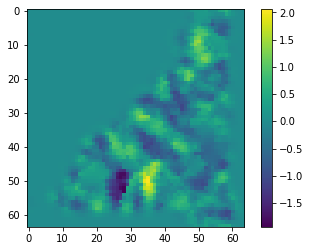

 85%|████████▌ | 17/20 [00:17<00:03,  1.01s/it]

1111 0.6614517
0.6614517
0.6614517
HELLO 1.6298338e-11


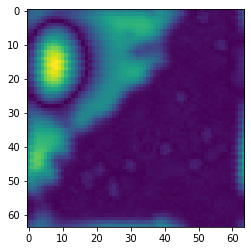

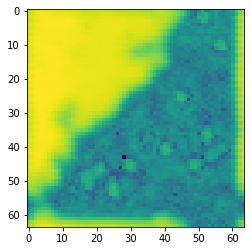

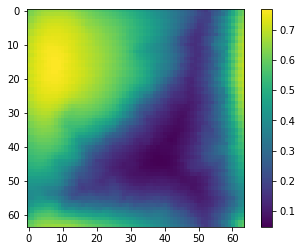

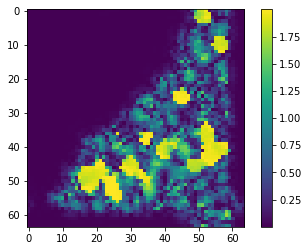

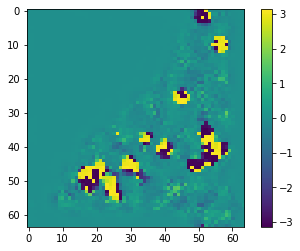

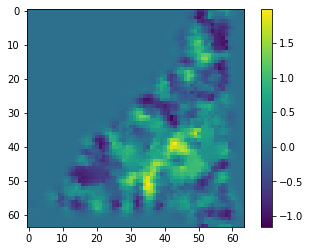

 90%|█████████ | 18/20 [00:18<00:02,  1.02s/it]

1111 0.66153705
0.66153705
0.66153705
HELLO 1.9326567e-10


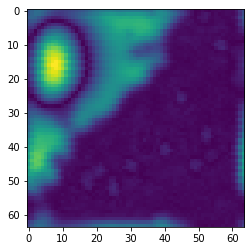

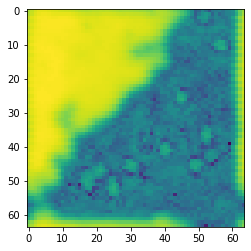

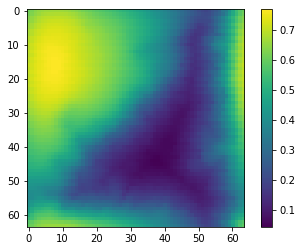

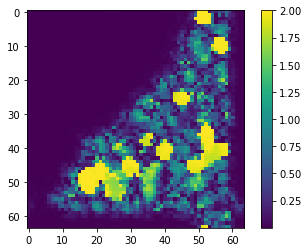

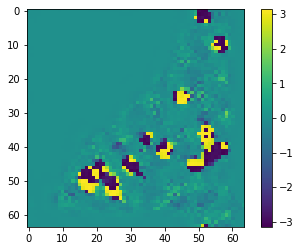

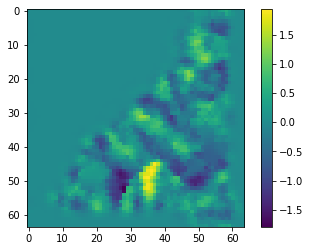

 95%|█████████▌| 19/20 [00:20<00:01,  1.03s/it]

1111 0.661809
0.661809
0.661809
HELLO -3.6100098e-10


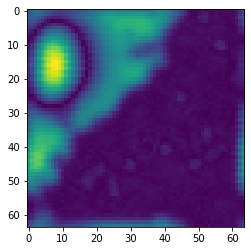

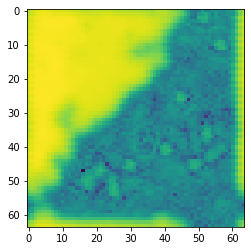

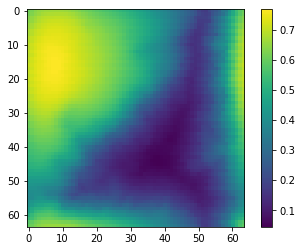

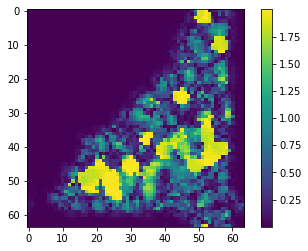

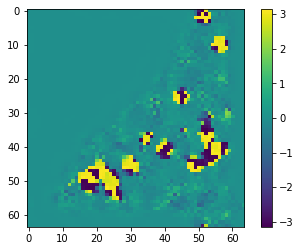

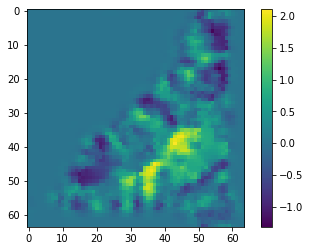

100%|██████████| 20/20 [00:21<00:00,  1.06s/it]

end of loop, memory used, and total/1e9: 0.042637824 0.458135552
normalized by data.nbytes memory used and total normalized: 10.1656494140625 109.22802734375
----
total time: 21.3516214042902
{'Overlap': 0, 'Split': 0, 'Prox_data': 0.003339258022606373, 'Data_prox_tot': 0.4446695791557431, 'Propagate': 0.4348248690366745, 'mse_data': 0.0064482307061553, 'Gramiam': 0.00012487545609474182, 'Gramiam_completion': 0.00028098560869693756, 'Precondition': 0, 'Eigensolver': 9.856703008525074, 'Sync_setup': 1.315586268901825e-05, 'fd': 0}
total time operators benchmarked: 10.746403962373734
after normalization


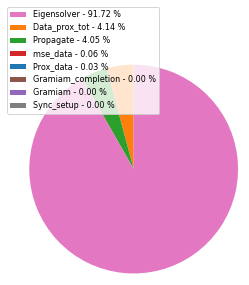

solver timers:
 {'solver_tot': 21.349344394169748, 'solver_loop': 21.187280454672873, 'ProxD': 0.4456159695982933, 'Overlap': 0.00742728728801012, 'Sync': 20.694957084022462, 'illuminate&split': 0.002261931076645851, 'refine_illumination': 1.1967495083808899e-05, 'mse_step': 0.005240229889750481, 'mse_truth': 0.013079071417450905, 'copies': 0.0013816943392157555, 'loop_intrnl': 21.170095342211425, 'solver_final': 0.006675312295556068, 'solver_init': 0.155384361743927}
solver timers after normalization by 21.187280454672873 :
 {'solver_tot': 1.0076491147527682, 'solver_loop': 1.0, 'ProxD': 0.02103224010045198, 'Overlap': 0.00035055406492115536, 'Sync': 0.9767632579507471, 'illuminate&split': 0.00010675891516539492, 'refine_illumination': 5.648433789986226e-07, 'mse_step': 0.00024732904730086506, 'mse_truth': 0.000617307702393976, 'copies': 6.52133879178921e-05, 'loop_intrnl': 0.9991888948419684, 'solver_final': 0.0003150622520826557, 'solver_init': 0.007333851179076494}
mse timings: 0.0

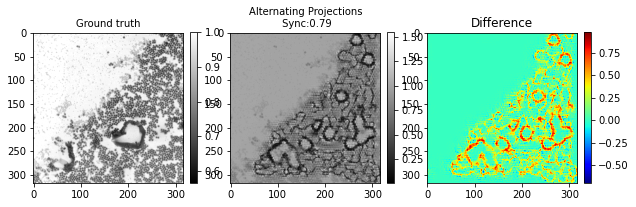

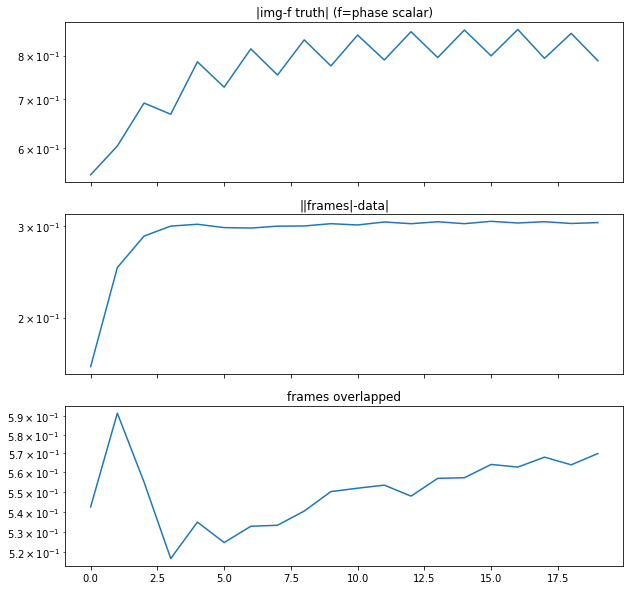

solver tot (seconds) : 21.349344394169748 loop: 21.187280454672873 seconds
proxD : 2.103224010045198 %
Overlap : 0.03505540649211553 %
illuminate and split : 0.010675891516539492 %
mse: 0.11689811755851934 %
proxD (propagate(ffts), mse, prox)%: (97.7860617005193, 1.4501173474466178, 0.7509526576894111)


In [1]:
fname_in = "poster_64x64.h5"
%run -i ptycho_reconstruct.py

using GPU
loaded data, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
Split and Overlap, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
geometry: img size: (317, 317) frames: (16, 16, 4096)
not refining illumination, starting with good one, maxiter: 10
start AP memory used, and total: 16533504 458135552
normalized by data.nbytes memory used and total normalized: 3.94189453125 109.22802734375
data size 4194304
----
after Prox_data, memory used, and total: 16567296 458135552
normalized by data.nbytes memory used and total normalized: 3.949951171875 109.22802734375
----
after frames initial, memory used, and total: 24955904 458135552
normalized by data.nbytes memory used and total normalized: 5.949951171875 109.22802734375
----
start loop, memory used, and total: 34182656 45813555

100%|██████████| 10/10 [16:18<00:00, 97.84s/it]


end of loop, memory used, and total/1e9: 0.042637824 0.458135552
normalized by data.nbytes memory used and total normalized: 10.1656494140625 109.22802734375
----
total time: 978.5949304513633
{'Overlap': 0, 'Split': 0, 'Prox_data': 0.0027186674997210503, 'Data_prox_tot': 0.41198740154504776, 'Propagate': 0.4053521519526839, 'mse_data': 0.0038816509768366814, 'Gramiam': 0.00014138128608465195, 'Gramiam_completion': 0.00035461410880088806, 'Precondition': 0, 'Eigensolver': 977.711768578738, 'Sync_setup': 2.5120563805103302e-05, 'fd': 0}
total time operators benchmarked: 978.536229566671
after normalization


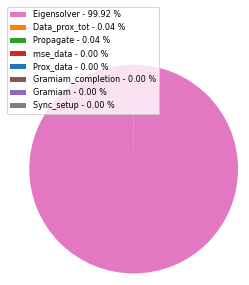

solver timers:
 {'solver_tot': 978.5939633427188, 'solver_loop': 978.3673106413335, 'ProxD': 0.41295307129621506, 'Overlap': 0.00565333291888237, 'Sync': 977.9026951240376, 'illuminate&split': 0.0015505747869610786, 'refine_illumination': 2.3806467652320862e-05, 'mse_step': 0.005711033008992672, 'mse_truth': 0.015398263931274414, 'copies': 0.0009528044611215591, 'loop_intrnl': 978.3450284590945, 'solver_final': 0.10247521568089724, 'solver_init': 0.12417224794626236}
solver timers after normalization by 978.3673106413335 :
 {'solver_tot': 1.000231664221525, 'solver_loop': 1.0, 'ProxD': 0.00042208388077226184, 'Overlap': 5.778333819408307e-06, 'Sync': 0.9995251113643695, 'illuminate&split': 1.5848595615328307e-06, 'refine_illumination': 2.433285269590149e-08, 'mse_step': 5.837309716786235e-06, 'mse_truth': 1.57387350985599e-05, 'copies': 9.73871930059665e-07, 'loop_intrnl': 0.9999772251362073, 'solver_final': 0.00010474104619636494, 'solver_init': 0.00012691782175844134}
mse timings: 0.

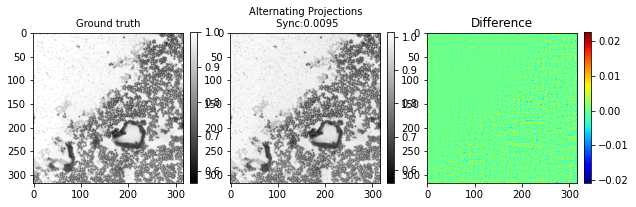

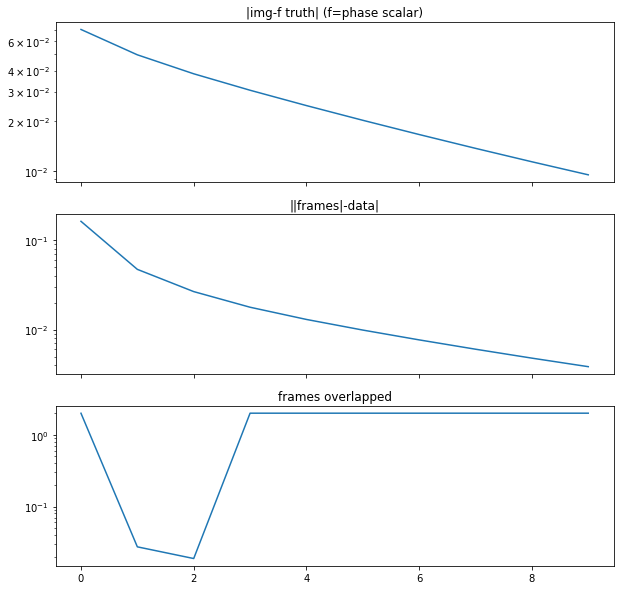

solver tot (seconds) : 978.5939633427188 loop: 978.3673106413335 seconds
proxD : 0.04220838807722618 %
Overlap : 0.0005778333819408308 %
illuminate and split : 0.00015848595615328308 %
mse: 0.0025543523015626774 %
proxD (propagate(ffts), mse, prox)%: (98.38945327758078, 0.9421771059696474, 0.6598909310152253)


In [1]:
fname_in = "poster_64x64.h5"
%run -i ptycho_reconstruct.py

using GPU
loaded data, memory used, and total: 24957952 726817280
normalized by data.nbytes memory used and total normalized: 5.950439453125 173.2867431640625
data size 4194304
----
Split and Overlap, memory used, and total: 24957952 726817280
normalized by data.nbytes memory used and total normalized: 5.950439453125 173.2867431640625
data size 4194304
----
geometry: img size: (317, 317) frames: (16, 16, 4096)
not refining illumination, starting with good one, maxiter: 2
start AP memory used, and total: 25762304 726817280
normalized by data.nbytes memory used and total normalized: 6.1422119140625 173.2867431640625
data size 4194304
----
after Prox_data, memory used, and total: 25796096 726817280
normalized by data.nbytes memory used and total normalized: 6.1502685546875 173.2867431640625
----
after frames initial, memory used, and total: 34184704 726817280
normalized by data.nbytes memory used and total normalized: 8.1502685546875 173.2867431640625
----
start loop, memory used, and tot

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

end of loop, memory used, and total/1e9: 0.051833856 0.72681728
normalized by data.nbytes memory used and total normalized: 12.358154296875 173.2867431640625
----
total time: 1.2605323931202292
{'Overlap': 0, 'Split': 0, 'Prox_data': 0.00010526087135076523, 'Data_prox_tot': 0.0014535067602992058, 'Propagate': 0.0006608357653021812, 'mse_data': 0.0006795376539230347, 'Gramiam': 9.526312351226807e-05, 'Gramiam_completion': 0.0002084728330373764, 'Precondition': 0, 'Eigensolver': 1.0641589174047112, 'Sync_setup': 1.0747462511062622e-06, 'fd': 0}
total time operators benchmarked: 1.0673628691583872
after normalization


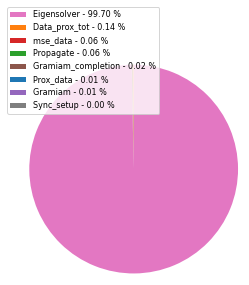

solver timers:
 {'solver_tot': 6.938747081336155, 'solver_loop': 1.258431131951511, 'ProxD': 0.9962335982072356, 'Overlap': 0.004812163581961538, 'Sync': 5.179289832576283, 'illuminate&split': 0.0004882119872884771, 'refine_illumination': 2.744385897215062e-06, 'mse_step': 0.003414741161680046, 'mse_truth': 0.43161493927831296, 'copies': 0.0004951706503976437, 'loop_intrnl': 6.616402133874621, 'solver_final': 0.009477569825074, 'solver_init': 0.001333148218691349}
solver timers after normalization by 1.258431131951511 :
 {'solver_tot': 5.5138075538356235, 'solver_loop': 1.0, 'ProxD': 0.7916472923411607, 'Overlap': 0.003823938759762785, 'Sync': 4.1156720467845584, 'illuminate&split': 0.000387952884264221, 'refine_illumination': 2.1807994315582516e-06, 'mse_step': 0.002713490690892746, 'mse_truth': 0.34297859320198676, 'copies': 0.00039348251789492704, 'loop_intrnl': 5.25765929170414, 'solver_final': 0.007531258234510352, 'solver_init': 0.001059373202746479}
mse timings: 0.34637162154680

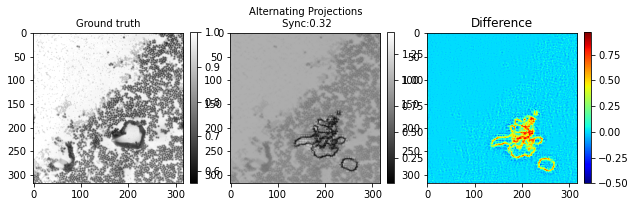

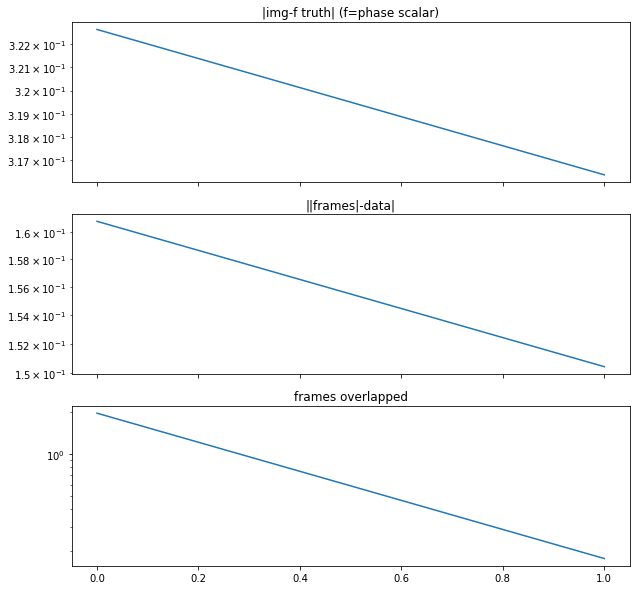

solver tot (seconds) : 6.938747081336155 loop: 1.258431131951511 seconds
proxD : 79.16472923411607 %
Overlap : 0.3823938759762785 %
illuminate and split : 0.038795288426422096 %
mse: 34.623207184825475 %
proxD (propagate(ffts), mse, prox)%: (45.4649254721146, 46.75159913141038, 7.241856331586457)


In [2]:
fname_in = "poster_64x64.h5"
%run -i ptycho_reconstruct.py

##Test the gradient ##

In [2]:
from Operators import gradientf
from Operators import evalf
import cupy as xp
from cupyx.scipy.sparse.linalg import eigsh
from cupyx.scipy.sparse import csr_matrix
from scipy import sparse

In [3]:
H = sparse.load_npz('saveH.npz')
H = csr_matrix(H)
print(type(H))

<class 'cupyx.scipy.sparse._csr.csr_matrix'>


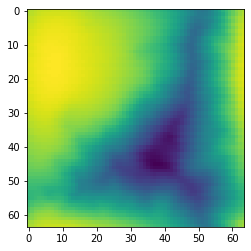

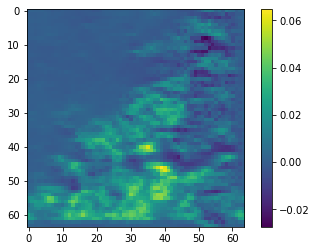

In [6]:
eigenvectors0 = xp.ones((H.shape[0],1),xp.complex64)
        
for _ in range(1000):
    eigenvectors0 = H * eigenvectors0


plt.imshow((xp.abs(xp.reshape(eigenvectors0,(64,64)))).get() ** 0.01)
plt.show()
plt.imshow((xp.angle(xp.reshape(eigenvectors0,(64,64)))).get())
plt.colorbar()
plt.show()

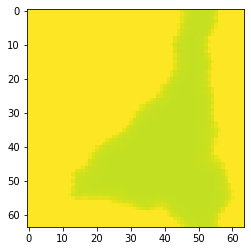

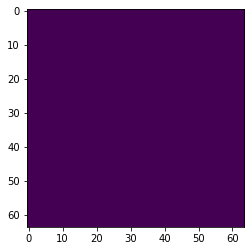

In [31]:

diff = (xp.reshape(eigenvectors0,(64,64))).astype(xp.complex128) - xp.reshape(eigenvectors[:,-1],(64,64))

plt.imshow(xp.abs(diff).get())
plt.clim(-0.0001,0.00001)
plt.show()
plt.imshow(xp.angle(diff).get())
plt.clim(-0.00001,0.00001)
plt.show()

In [4]:
v0 = xp.ones((H.shape[0],),xp.complex64)
eigenvalues, eigenvectors = eigsh(H, k=64, v0 = v0, which="LM", tol=1e-9)

complex128


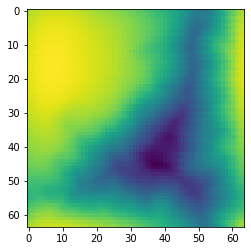

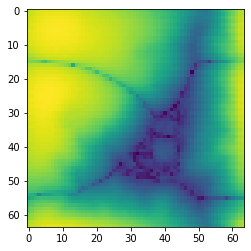

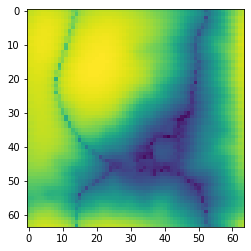

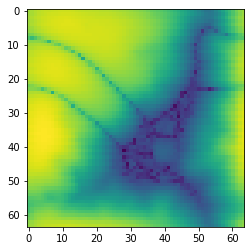

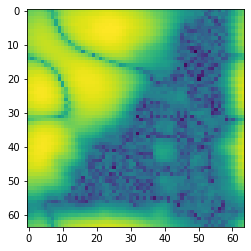

In [9]:
v0 = xp.ones((H.shape[0],),xp.complex128)
H1 = H.astype(xp.complex128)
print(v0.dtype)
v0 /= xp.linalg.norm(v0)
v0 = xp.reshape(v0,(64**2,))
eigenvalues, eigenvectors = eigsh(H1, k=6,ncv=18, v0 = v0, maxiter = 100, which="LM", tol=1e-9)
#eigenvalues, eigenvectors = eigsh(H, k=6,ncv=18,maxiter = 10, which="LM", tol=1e-9)
import matplotlib.pyplot as plt

for i in range(1,6):
    plt.imshow((xp.abs(xp.reshape(eigenvectors[:,-i],(64,64)))).get()**0.01)
    plt.show()

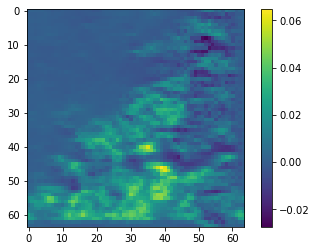

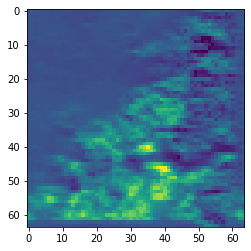

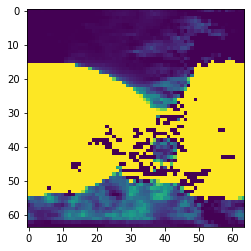

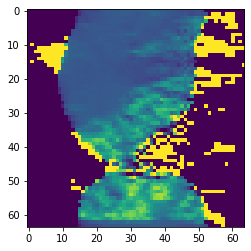

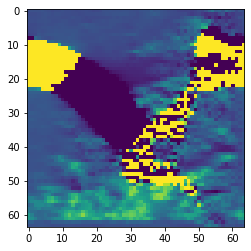

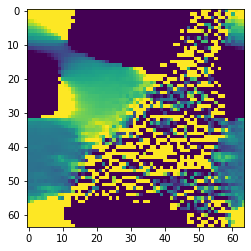

In [10]:
plt.imshow((xp.angle(xp.reshape(eigenvectors0,(64,64)))).get())
plt.colorbar()
plt.show()
for i in range(1,6):
    so = xp.conj(xp.sum(eigenvectors[:,-i]))
    plt.imshow((xp.angle(xp.reshape(eigenvectors[:,-i] * so,(64,64)))).get())
    plt.clim(-0.02,0.06)
    plt.show()


In [4]:
print(evalf(1,0.01,eigenvectors[:,-1],eigenvectors[:,-2]))

4042.751426169411


In [6]:
grad1,grad2 = gradientf(1,0.01,eigenvectors[:,-1],eigenvectors[:,-2])

In [18]:
ss = 1

In [19]:
print(evalf(1 - ss *grad1 ,0.01 - ss*grad2,eigenvectors[:,-1],eigenvectors[:,-2]))

3360.329699837032


Using gradient decent

using GPU
loaded data, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
Split and Overlap, memory used, and total: 5131776 5150720
normalized by data.nbytes memory used and total normalized: 1.2235107421875 1.22802734375
data size 4194304
----
geometry: img size: (317, 317) frames: (16, 16, 4096)
not refining illumination, starting with good one, maxiter: 2
start AP memory used, and total: 16533504 458135552
normalized by data.nbytes memory used and total normalized: 3.94189453125 109.22802734375
data size 4194304
----
after Prox_data, memory used, and total: 16567296 458135552
normalized by data.nbytes memory used and total normalized: 3.949951171875 109.22802734375
----
after frames initial, memory used, and total: 24955904 458135552
normalized by data.nbytes memory used and total normalized: 5.949951171875 109.22802734375
----
start loop, memory used, and total: 34182656 458135552

  0%|          | 0/2 [00:00<?, ?it/s]

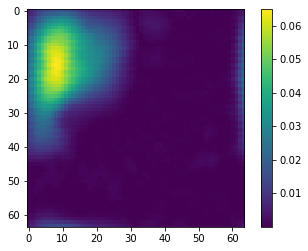

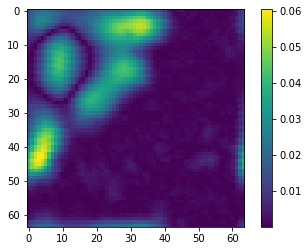

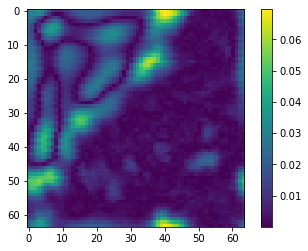

1.0 1.0
32.001600047271786
decent? 3184.959782762797 32.0 0.32j
decent? 2529.395493571443 (23.35162332288975-8.529373035617343j) (24.980889489357935+18.014191463500502j)
1.0 1.0
39.580354364909915


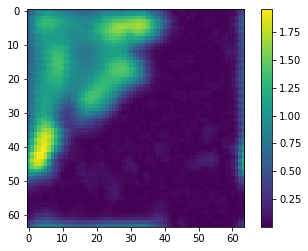

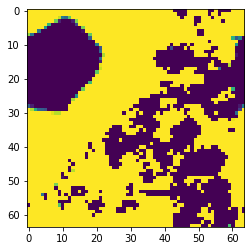

 50%|█████     | 1/2 [00:05<00:05,  5.55s/it]

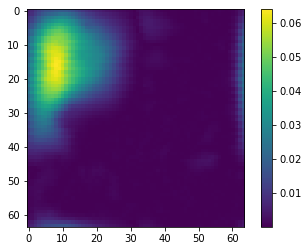

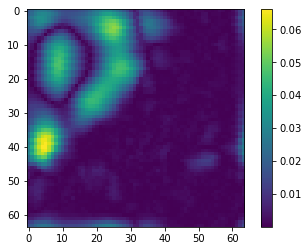

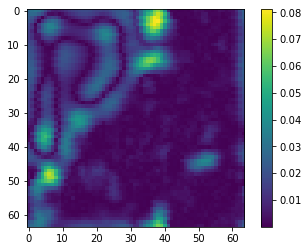

0.99999994 1.0
32.001599978148796
decent? 3179.5104244537056 32.0 0.32j
decent? 2621.2955057923864 (21.32227741551381-9.980904972421934j) (23.84017339847981+18.764130545749715j)
0.99999994 1.0
38.4018806599762


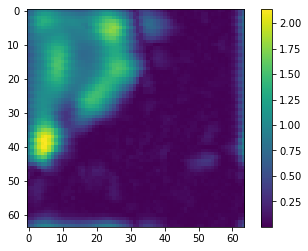

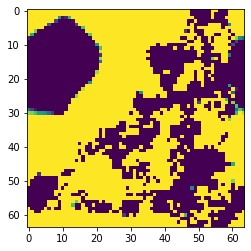

100%|██████████| 2/2 [00:09<00:00,  4.73s/it]

end of loop, memory used, and total/1e9: 0.042637824 0.458135552
normalized by data.nbytes memory used and total normalized: 10.1656494140625 109.22802734375
----
total time: 9.633832436986268
{'Overlap': 0, 'Split': 0, 'Prox_data': 0.003579668700695038, 'Data_prox_tot': 0.4830155745148659, 'Propagate': 0.4756027068942785, 'mse_data': 0.0038224635645747185, 'Gramiam': 0.00014716386795043945, 'Gramiam_completion': 0.0002860706299543381, 'Precondition': 0, 'Eigensolver': 8.825264878571033, 'Sync_setup': 1.2563541531562805e-06, 'fd': 0}
total time operators benchmarked: 9.791719783097506
after normalization


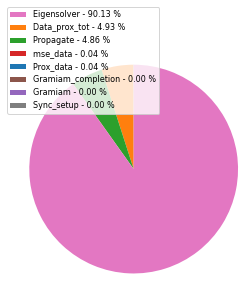

solver timers:
 {'solver_tot': 9.630066557787359, 'solver_loop': 9.469994593411684, 'ProxD': 0.4831615211442113, 'Overlap': 0.005014022812247276, 'Sync': 8.953832432627678, 'illuminate&split': 0.00018786638975143433, 'refine_illumination': 9.071081876754761e-07, 'mse_step': 0.0027661947533488274, 'mse_truth': 0.01518547348678112, 'copies': 0.00016422104090452194, 'loop_intrnl': 9.460326416417956, 'solver_final': 0.010400386527180672, 'solver_init': 0.14965265151113272}
solver timers after normalization by 9.469994593411684 :
 {'solver_tot': 1.0169030681904547, 'solver_loop': 1.0, 'ProxD': 0.05102025311401433, 'Overlap': 0.0005294641684099327, 'Sync': 0.9454949888627072, 'illuminate&split': 1.9838067265860297e-05, 'refine_illumination': 9.578761410344997e-08, 'mse_step': 0.00029210098549298865, 'mse_truth': 0.0016035356025805674, 'copies': 1.7341196901925502e-05, 'loop_intrnl': 0.9989790725962554, 'solver_final': 0.0010982463004167147, 'solver_init': 0.01580282333162542}
mse timings: 0.

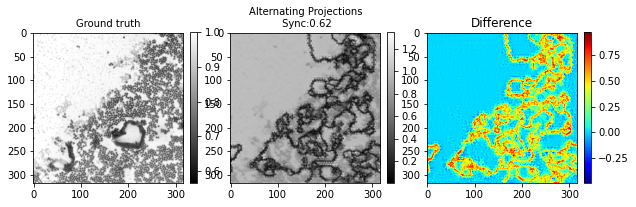

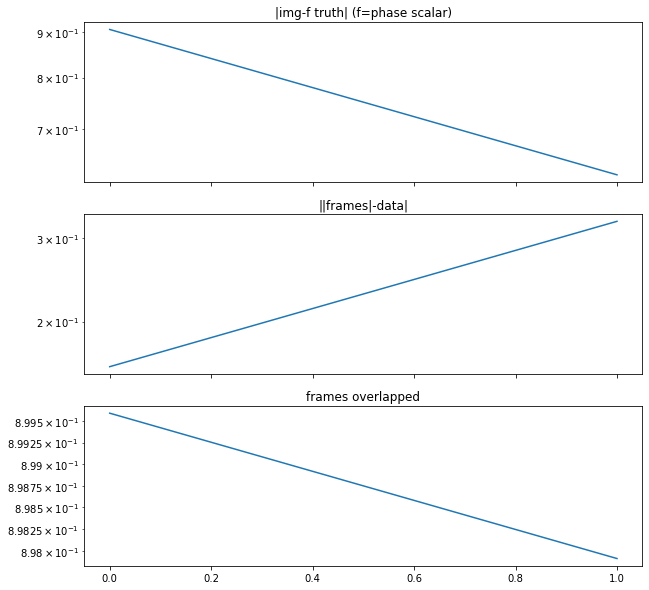

solver tot (seconds) : 9.630066557787359 loop: 9.469994593411684 seconds
proxD : 5.102025311401433 %
Overlap : 0.05294641684099327 %
illuminate and split : 0.0019838067265860295 %
mse: 0.22992760544819132 %
proxD (propagate(ffts), mse, prox)%: (98.4652942862075, 0.7913748057531991, 0.7411083388543749)


In [1]:
fname_in = "poster_64x64.h5"
%run -i ptycho_reconstruct.py

In [ ]:
fname_in = "poster_64x64.h5"
%run -i ptycho_reconstruct.py